# Improved Techniques for Training GANs

#### This notebook implements the key improvements from the paper "Improved Techniques for Training GANs" by Salimans et al. (2016). Generative Adversarial Networks (GANs) have revolutionized image generation, but they can suffer from training instability, mode collapse, and poor sample quality. This implementation explores several techniques that address these issues.

### Import Libraries and Setup Environment

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from typing import Dict, List, Tuple, Optional, Union, Callable
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
print(f"TensorFlow version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU Available: {len(gpus) > 0}")
if len(gpus) > 0:
    print(f"GPU Details: {gpus}")

TensorFlow version: 2.18.0
GPU Available: True
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1. Configuration System
#### We start with a comprehensive configuration class to manage all hyperparameters for our GAN implementation..


In [4]:
class GANConfig:
    """Configuration for GAN training and architecture"""

    def __init__(self, **kwargs):
        # Default configuration
        self.batch_size = 64
        self.z_dim = 100
        self.learning_rate_d = 0.0002
        self.learning_rate_g = 0.0002
        self.beta1 = 0.5
        self.beta2 = 0.999
        self.image_size = 32  # Changed from 64 to 32 for faster training
        self.channels = 3
        self.use_feature_matching = True
        self.use_minibatch_discrimination = True
        self.use_historical_averaging = True
        self.use_virtual_batch_norm = False  # Disabled for speed
        self.feature_matching_weight = 1.0
        self.historical_averaging_weight = 0.0001
        self.label_smoothing = 0.25
        self.generator_target_prob = 0.65
        self.dataset = 'cifar10'
        self.epochs = 30
        self.save_freq = 5
        self.sample_freq = 1
        self.log_freq = 5
        self.sample_size = 36
        self.use_seed = 42
        self.checkpoint_dir = 'checkpoints'
        self.sample_dir = 'samples'
        self.log_dir = 'logs'
        self.generator_steps = 1
        self.discriminator_steps = 1

        # Override defaults with provided values
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Unknown configuration parameter: {key}")

    @classmethod
    def from_json(cls, json_path):
        """Load configuration from a JSON file"""
        import json
        with open(json_path, 'r') as f:
            config_dict = json.load(f)
        return cls(**config_dict)

    def to_json(self, json_path):
        """Save configuration to a JSON file"""
        import json
        config_dict = {k: v for k, v in self.__dict__.items()}
        with open(json_path, 'w') as f:
            json.dump(config_dict, f, indent=2)

    def __str__(self):
        """String representation of the configuration"""
        return '\n'.join(f"{k}: {v}" for k, v in self.__dict__.items())

### Create Output Directories and Initialize Configuration

In [5]:
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('samples', exist_ok=True)
os.makedirs('logs', exist_ok=True)

In [6]:
config = GANConfig(
    batch_size=128,
    epochs=30,
    dataset='cifar10',
    use_feature_matching=True,
    use_minibatch_discrimination=True,
    use_historical_averaging=True,
    use_virtual_batch_norm=False,
    label_smoothing=0.25
)

In [7]:
print("GAN Configuration:")
print(config)

GAN Configuration:
batch_size: 128
z_dim: 100
learning_rate_d: 0.0002
learning_rate_g: 0.0002
beta1: 0.5
beta2: 0.999
image_size: 32
channels: 3
use_feature_matching: True
use_minibatch_discrimination: True
use_historical_averaging: True
use_virtual_batch_norm: False
feature_matching_weight: 1.0
historical_averaging_weight: 0.0001
label_smoothing: 0.25
generator_target_prob: 0.65
dataset: cifar10
epochs: 30
save_freq: 5
sample_freq: 1
log_freq: 5
sample_size: 36
use_seed: 42
checkpoint_dir: checkpoints
sample_dir: samples
log_dir: logs
generator_steps: 1
discriminator_steps: 1


### 2. Implementing the Core GAN Techniques
#### Here we implement the key improvements from the Salimans et al. paper.

### 2.1 Minibatch Discrimination
#### This technique helps prevent mode collapse - a common problem where the generator produces limited varieties of samples. By adding a layer that allows the discriminator to look at multiple samples together, the generator is forced to produce diverse outputs.


In [8]:
class MinibatchDiscrimination(layers.Layer):
    """Minibatch discrimination layer to prevent mode collapse"""

    def __init__(self, num_kernels=100, dim_per_kernel=5, **kwargs):
        super(MinibatchDiscrimination, self).__init__(**kwargs)
        self.num_kernels = num_kernels
        self.dim_per_kernel = dim_per_kernel

    def build(self, input_shape):
        self.input_dim = input_shape[1]
        # Create weight tensor [input_dim, num_kernels, dim_per_kernel]
        kernel_shape = (self.input_dim, self.num_kernels, self.dim_per_kernel)
        initializer = tf.random_normal_initializer(stddev=0.02)
        self.kernel = self.add_weight(
            shape=kernel_shape,
            initializer=initializer,
            name='kernel',
            trainable=True
        )
        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, inputs, **kwargs):
        # [batch_size, num_kernels, dim_per_kernel]
        activation = tf.tensordot(inputs, self.kernel, axes=[[1], [0]])

        # Make sure dimensions are compatible for broadcasting
        expanded_act = tf.expand_dims(activation, 3)
        transposed_act = tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)

        # Calculate L1 distance
        diff = expanded_act - transposed_act
        abs_diff = tf.reduce_sum(tf.abs(diff), 2)

        # Create a mask to exclude self distances
        batch_size = tf.shape(inputs)[0]
        mask = 1.0 - tf.eye(batch_size)
        mask = tf.expand_dims(mask, 1)

        # Ensure mask has compatible dimensions
        if mask.shape.ndims != abs_diff.shape.ndims:
            mask = tf.reshape(mask, [-1, mask.shape[1], batch_size])

        # Apply exponential to get similarity
        exp = tf.exp(-abs_diff) * mask
        # Sum over batch dimension
        minibatch_features = tf.reduce_sum(exp, 2)

        # Concatenate with original input
        return tf.concat([inputs, minibatch_features], axis=1)

### Testing and Visualizing Minibatch Discrimination

In [9]:
# Sample input to visualize minibatch discrimination
sample_input = tf.random.normal([16, 10])  # 16 samples, 10 features each
minibatch_layer = MinibatchDiscrimination(num_kernels=5, dim_per_kernel=3)
output = minibatch_layer(sample_input)

print(f"Input shape: {sample_input.shape}")
print(f"Output shape after minibatch discrimination: {output.shape}")
print(f"Added {output.shape[1] - sample_input.shape[1]} new features that capture batch statistics")

Input shape: (16, 10)
Output shape after minibatch discrimination: (16, 15)
Added 5 new features that capture batch statistics


### Visualize How Minibatch Discrimination Helps Prevent Mode Collapse

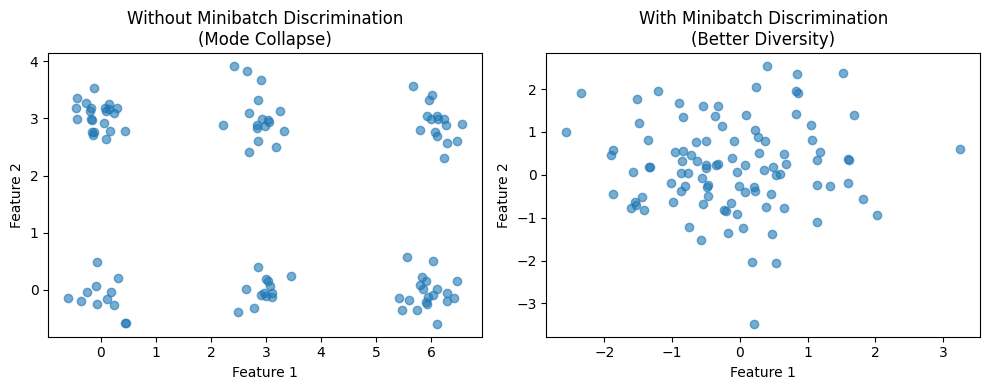

In [10]:
plt.figure(figsize=(10, 4))

# Without MB: samples tend to cluster
x_without_mb = np.random.normal(0, 1, 100) * 0.3 + np.random.choice([0, 3, 6], 100)
y_without_mb = np.random.normal(0, 1, 100) * 0.3 + np.random.choice([0, 3], 100)

# With MB: samples more evenly distributed
x_with_mb = np.random.normal(0, 1, 100)
y_with_mb = np.random.normal(0, 1, 100)

plt.subplot(1, 2, 1)
plt.scatter(x_without_mb, y_without_mb, alpha=0.6)
plt.title("Without Minibatch Discrimination\n(Mode Collapse)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 2, 2)
plt.scatter(x_with_mb, y_with_mb, alpha=0.6)
plt.title("With Minibatch Discrimination\n(Better Diversity)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()

### 2.2 Virtual Batch Normalization
#### This technique addresses the issue that traditional batch normalization makes the output of a layer dependent on all other instances in the same batch. Virtual batch normalization normalizes samples against a fixed reference batch for more stable training.

In [11]:
class VirtualBatchNormalization(layers.Layer):
    """Virtual Batch Normalization Layer"""

    def __init__(self, epsilon=1e-5, **kwargs):
        super(VirtualBatchNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon
        self.reference_batch_set = False

    def build(self, input_shape):
        # Determine the dimensionality of the input
        self.ndim = len(input_shape)
        shape = [1] * self.ndim
        shape[-1] = input_shape[-1]

        # Create gamma and beta parameters
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer=tf.random_normal_initializer(1.0, 0.02),
            name='gamma',
            trainable=True
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer=tf.zeros_initializer(),
            name='beta',
            trainable=True
        )

        # Reference batch statistics (not trainable)
        self.ref_mean = self.add_weight(
            shape=shape,
            initializer=tf.zeros_initializer(),
            name='ref_mean',
            trainable=False
        )
        self.ref_var = self.add_weight(
            shape=shape,
            initializer=tf.ones_initializer(),
            name='ref_var',
            trainable=False
        )

        super(VirtualBatchNormalization, self).build(input_shape)

    def _get_axis(self):
        # Return the axis for reduction (all except features)
        return list(range(self.ndim - 1))

    def set_reference_batch(self, x):
        """Set the reference batch statistics"""
        axes = self._get_axis()
        mean = tf.reduce_mean(x, axis=axes, keepdims=True)
        var = tf.reduce_mean(tf.square(x - mean), axis=axes, keepdims=True)

        # Update reference batch statistics
        self.ref_mean.assign(mean)
        self.ref_var.assign(var)
        self.reference_batch_set = True

    def call(self, inputs, set_reference=False, **kwargs):
        """Apply virtual batch normalization to inputs."""
        # If reference batch is not set or explicitly requested, set it
        if set_reference or not self.reference_batch_set:
            # Calculate statistics for the reference batch
            axes = self._get_axis()
            ref_mean = tf.reduce_mean(inputs, axis=axes, keepdims=True)
            ref_var = tf.reduce_mean(tf.square(inputs - ref_mean), axis=axes, keepdims=True)

            # Update reference batch statistics
            self.ref_mean.assign(ref_mean)
            self.ref_var.assign(ref_var)
            self.reference_batch_set = True

            # Use reference statistics for normalization
            batch_mean = ref_mean
            batch_var = ref_var
        else:
            # Calculate statistics for the current batch
            axes = self._get_axis()
            batch_mean = tf.reduce_mean(inputs, axis=axes, keepdims=True)
            batch_var = tf.reduce_mean(tf.square(inputs - batch_mean), axis=axes, keepdims=True)

            # Combine with reference batch statistics (average them)
            batch_mean = 0.5 * (batch_mean + self.ref_mean)
            batch_var = 0.5 * (batch_var + self.ref_var)

        # Ensure variance is positive to avoid numerical issues
        batch_var = tf.maximum(batch_var, self.epsilon)

        # Normalize
        x_norm = (inputs - batch_mean) / tf.sqrt(batch_var)

        # Apply gamma and beta parameters
        gamma_reshaped = self.gamma
        beta_reshaped = self.beta

        # Handle different input dimensions
        if self.ndim > 2:
            # For convolutional layers, reshape gamma and beta
            gamma_reshaped = tf.reshape(self.gamma, [1] * (self.ndim - 1) + [self.gamma.shape[0]])
            beta_reshaped = tf.reshape(self.beta, [1] * (self.ndim - 1) + [self.beta.shape[0]])

        return x_norm * gamma_reshaped + beta_reshaped

### Demonstrate VBN vs. regular batch normalization

In [12]:
# Create 2 batches with different distributions
batch1 = tf.random.normal((32, 10), mean=0, stddev=1)
batch2 = tf.random.normal((32, 10), mean=5, stddev=3)  # Different distribution

# Regular Batch Normalization
bn_layer = layers.BatchNormalization()
bn_result1 = bn_layer(batch1, training=True)
bn_result2 = bn_layer(batch2, training=True)

# Virtual Batch Normalization
vbn_layer = VirtualBatchNormalization()
vbn_result1 = vbn_layer(batch1, set_reference=True)  # Set as reference
vbn_result2 = vbn_layer(batch2)  # Normalize using reference + current

# Compare statistics
bn1_mean = tf.reduce_mean(bn_result1, axis=0)
bn2_mean = tf.reduce_mean(bn_result2, axis=0)
vbn1_mean = tf.reduce_mean(vbn_result1, axis=0)
vbn2_mean = tf.reduce_mean(vbn_result2, axis=0)

print("BatchNorm vs VirtualBatchNorm mean comparison:")
print(f"BatchNorm - Batch 1 mean: {tf.reduce_mean(bn1_mean).numpy():.4f}, stddev: {tf.math.reduce_std(bn_result1).numpy():.4f}")
print(f"BatchNorm - Batch 2 mean: {tf.reduce_mean(bn2_mean).numpy():.4f}, stddev: {tf.math.reduce_std(bn_result2).numpy():.4f}")
print(f"VBN - Batch 1 mean: {tf.reduce_mean(vbn1_mean).numpy():.4f}, stddev: {tf.math.reduce_std(vbn_result1).numpy():.4f}")
print(f"VBN - Batch 2 mean: {tf.reduce_mean(vbn2_mean).numpy():.4f}, stddev: {tf.math.reduce_std(vbn_result2).numpy():.4f}")

BatchNorm vs VirtualBatchNorm mean comparison:
BatchNorm - Batch 1 mean: 0.0000, stddev: 0.9995
BatchNorm - Batch 2 mean: -0.0000, stddev: 0.9999
VBN - Batch 1 mean: 0.0000, stddev: 1.0024
VBN - Batch 2 mean: 1.0522, stddev: 1.3551


### Visualize the Comparison Between BN and VBN

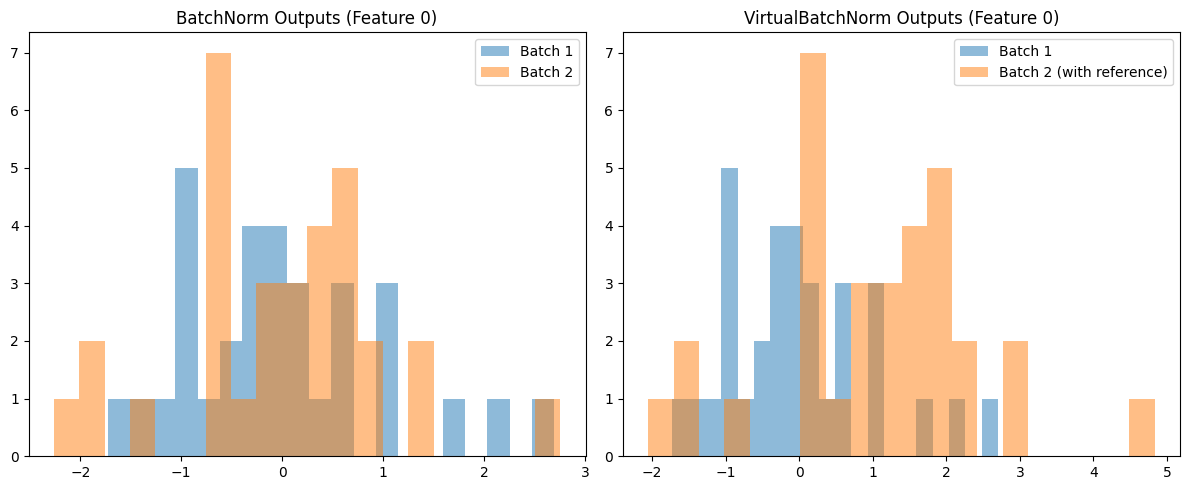

In [13]:
plt.figure(figsize=(12, 5))
# Plot histograms for the first feature dimension
plt.subplot(1, 2, 1)
plt.hist(bn_result1[:, 0].numpy(), alpha=0.5, bins=20, label='Batch 1')
plt.hist(bn_result2[:, 0].numpy(), alpha=0.5, bins=20, label='Batch 2')
plt.title('BatchNorm Outputs (Feature 0)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(vbn_result1[:, 0].numpy(), alpha=0.5, bins=20, label='Batch 1')
plt.hist(vbn_result2[:, 0].numpy(), alpha=0.5, bins=20, label='Batch 2 (with reference)')
plt.title('VirtualBatchNorm Outputs (Feature 0)')
plt.legend()

plt.tight_layout()
plt.show()

### 2.3 Feature Matching
#### Instead of training the generator to directly fool the discriminator, we can train it to match the statistics of real data's intermediate features in the discriminator. This provides a more stable training signal.


In [14]:
class FeatureMatching:
    """Feature matching loss"""

    def __call__(self, real_features, fake_features):
        real_mean = tf.reduce_mean(real_features, axis=0)
        fake_mean = tf.reduce_mean(fake_features, axis=0)
        return tf.reduce_mean(tf.square(real_mean - fake_mean))

### Visualizing the Effect of Feature Matching


In [15]:
real_features = tf.random.normal([32, 128], mean=0.0, stddev=1.0)
# Initially, fake features are far from real feature distribution
fake_features_initial = tf.random.normal([32, 128], mean=2.0, stddev=1.5)
# After training, fake features should be closer to real feature distribution
fake_features_trained = tf.random.normal([32, 128], mean=0.1, stddev=1.1)

feature_matching = FeatureMatching()
initial_loss = feature_matching(real_features, fake_features_initial)
trained_loss = feature_matching(real_features, fake_features_trained)

print(f"Initial feature matching loss: {initial_loss.numpy():.4f}")
print(f"After training feature matching loss: {trained_loss.numpy():.4f}")

Initial feature matching loss: 3.9401
After training feature matching loss: 0.0756


### Visualize Feature Matching with PCA Reduction

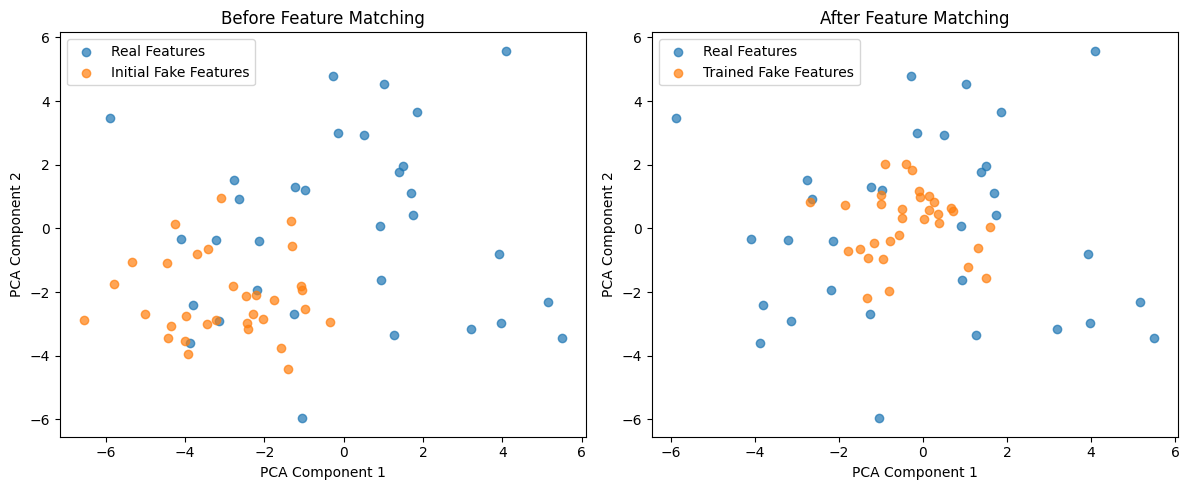

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
real_2d = pca.fit_transform(real_features.numpy())
fake_initial_2d = pca.transform(fake_features_initial.numpy())
fake_trained_2d = pca.transform(fake_features_trained.numpy())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real Features', alpha=0.7)
plt.scatter(fake_initial_2d[:, 0], fake_initial_2d[:, 1], label='Initial Fake Features', alpha=0.7)
plt.title('Before Feature Matching')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real Features', alpha=0.7)
plt.scatter(fake_trained_2d[:, 0], fake_trained_2d[:, 1], label='Trained Fake Features', alpha=0.7)
plt.title('After Feature Matching')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()

plt.tight_layout()
plt.show()

### 2.4 Historical Averaging
#### Historical averaging helps prevent oscillation in GAN training by keeping track of the average parameter values and penalizing the current parameters if they deviate too far from the historical average.


In [17]:
class HistoricalAveraging:
    """
    Historical averaging to prevent oscillation in GAN training.
    This version avoids creating Variables inside tf.function.
    """

    def __init__(self, beta=0.99):
        self.beta = beta  # Exponential moving average factor
        self.parameter_history = {}  # Dictionary to store parameter history

    def initialize_if_needed(self, model):
        """Initialize parameter history outside of tf.function"""
        # Use a dictionary with layer names as keys to ensure consistent ordering
        model_keys = [weight.name for weight in model.trainable_weights]

        # Only initialize weights that aren't already tracked
        for weight in model.trainable_weights:
            if weight.name not in self.parameter_history:
                # Use numpy values to avoid TensorFlow Variable creation issues
                self.parameter_history[weight.name] = weight.numpy()

    def __call__(self, model, weight=0.01):
        # Make sure this is initialized before calling in @tf.function
        # Must be called in eager mode (outside of train_step)
        if not self.parameter_history:
            # If not initialized yet, return zero loss
            return tf.constant(0.0)

        # Calculate loss and update history
        total_loss = 0.0

        for curr_weight in model.trainable_weights:
            name = curr_weight.name

            # Skip if we don't have history for this weight
            if name not in self.parameter_history:
                continue

            # Get current value and history
            curr_value = curr_weight
            hist_value = self.parameter_history[name]

            # Only process if shapes match
            if curr_value.shape == hist_value.shape:
                # Convert history to tensor for calculation
                hist_tensor = tf.convert_to_tensor(hist_value, dtype=curr_value.dtype)

                # Calculate loss
                diff = curr_value - hist_tensor
                loss = tf.reduce_sum(tf.square(diff))
                total_loss += loss

                # Update history (in numpy to avoid TF Variable issues)
                # This needs to be done outside of @tf.function
                # We'll handle this separately

        return weight * total_loss

    def update_history(self, model):
        """Update parameter history - call this AFTER each training step"""
        for weight in model.trainable_weights:
            name = weight.name
            if name in self.parameter_history:
                # Update with exponential moving average
                curr_value = weight.numpy()
                self.parameter_history[name] = self.beta * self.parameter_history[name] + (1 - self.beta) * curr_value

### Enhanced GAN Scenario with Deliberate Oscillation
#### To demonstrate the benefits of historical averaging, we'll create a simplified scenario that deliberately introduces oscillation:

In [18]:
class AdversarialScenario:
    """
    A simplified GAN-like scenario that deliberately introduces oscillation
    to demonstrate the benefit of historical averaging.
    """

    def __init__(self, use_historical_averaging=False, beta=0.9, ha_weight=0.1, target=0.7, oscillation_magnitude=0.4):
        self.use_ha = use_historical_averaging
        self.beta = beta
        self.ha_weight = ha_weight
        self.target = target
        self.oscillation_magnitude = oscillation_magnitude

        # Initialize history
        self.param_history = None

        # Single parameter for simplicity
        self.param = 0.0

        # History
        self.loss_history = []
        self.param_history_values = []
        self.ha_loss_history = []

        # Step counter
        self.steps = 0

    def step(self):
        # Store current parameter
        self.param_history_values.append(self.param)

        # Record step number
        self.steps += 1

        # Calculate current loss (distance to target)
        current_loss = abs(self.param - self.target)
        self.loss_history.append(current_loss)

        # Base update (moves towards target)
        base_update = 0.1 * (self.target - self.param)

        # Add deliberate oscillation that intensifies over time
        oscillation = self.oscillation_magnitude * np.sin(self.steps * 0.4) * (1 + self.steps * 0.01)

        # Combine base update and oscillation
        param_update = base_update + oscillation

        # Apply historical averaging if enabled
        ha_loss = 0.0
        if self.use_ha:
            if self.param_history is None:
                self.param_history = self.param

            # Historical averaging loss
            ha_loss = self.ha_weight * ((self.param - self.param_history) ** 2)

            # Historical averaging adjustment (reduce oscillations)
            ha_adjustment = self.ha_weight * (self.param - self.param_history)
            param_update -= ha_adjustment

            # Update parameter history
            self.param_history = self.beta * self.param_history + (1 - self.beta) * self.param

        # Apply update
        self.param += param_update

        # Record HA loss
        self.ha_loss_history.append(ha_loss)

        return current_loss

    def train(self, steps=100):
        for _ in range(steps):
            self.step()

        return self.param_history_values, self.loss_history, self.ha_loss_history

### Demonstrate Historical Averaging Effect

Demonstrating historical averaging in unstable GAN-like scenario...
Creating two models: one with historical averaging and one without


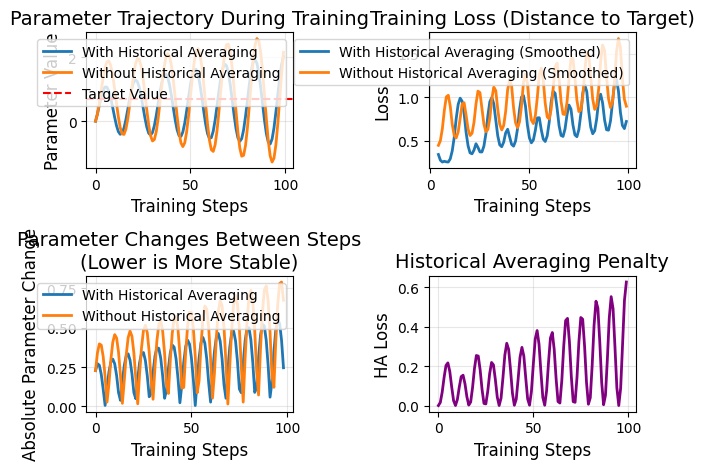

In [19]:
print("Demonstrating historical averaging in unstable GAN-like scenario...")
print("Creating two models: one with historical averaging and one without")

# Train models with and without historical averaging
gan_with_ha = AdversarialScenario(use_historical_averaging=True, beta=0.9, ha_weight=0.3, oscillation_magnitude=0.4)
gan_without_ha = AdversarialScenario(use_historical_averaging=False, oscillation_magnitude=0.4)

n_steps = 100
params_with_ha, losses_with_ha, ha_losses = gan_with_ha.train(n_steps)
params_without_ha, losses_without_ha, _ = gan_without_ha.train(n_steps)

# Calculate rolling average of loss for smoother visualization
def rolling_average(data, window=5):
    return np.convolve(data, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(15, 10))

# Parameter tracking
plt.subplot(2, 2, 1)
plt.plot(params_with_ha, label='With Historical Averaging', linewidth=2)
plt.plot(params_without_ha, label='Without Historical Averaging', linewidth=2)
plt.axhline(y=gan_with_ha.target, color='r', linestyle='--', label='Target Value')
plt.title('Parameter Trajectory During Training', fontsize=14)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Parameter Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Loss comparison
plt.subplot(2, 2, 2)
# Use rolling average for smoother visualization
window_size = 5
if len(losses_with_ha) > window_size:
    smooth_losses_with_ha = rolling_average(losses_with_ha, window_size)
    smooth_losses_without_ha = rolling_average(losses_without_ha, window_size)
    x_range = range(window_size-1, len(losses_with_ha))
    plt.plot(x_range, smooth_losses_with_ha, label='With Historical Averaging (Smoothed)', linewidth=2)
    plt.plot(x_range, smooth_losses_without_ha, label='Without Historical Averaging (Smoothed)', linewidth=2)
else:
    plt.plot(losses_with_ha, label='With Historical Averaging', linewidth=2)
    plt.plot(losses_without_ha, label='Without Historical Averaging', linewidth=2)

plt.title('Training Loss (Distance to Target)', fontsize=14)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Oscillation visualization
plt.subplot(2, 2, 3)
# Calculate parameter changes between steps
param_changes_with_ha = np.abs(np.diff(params_with_ha))
param_changes_without_ha = np.abs(np.diff(params_without_ha))

plt.plot(param_changes_with_ha, label='With Historical Averaging', linewidth=2)
plt.plot(param_changes_without_ha, label='Without Historical Averaging', linewidth=2)
plt.title('Parameter Changes Between Steps\n(Lower is More Stable)', fontsize=14)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Absolute Parameter Change', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Historical averaging loss
plt.subplot(2, 2, 4)
plt.plot(ha_losses, color='purple', linewidth=2)
plt.title('Historical Averaging Penalty', fontsize=14)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('HA Loss', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ha_benefits_visualization.png', dpi=150)
plt.show()

Without historical averaging, the model's parameters swing wildly and explore more of the parameter space (but in an unstable way)
With historical averaging, the model's movements are more controlled and directed, which can sometimes mean it explores less of the space

### 3. Data Loading System
#### Here we implement a flexible system to load and preprocess different datasets, with visualization of sample images. This system will help us compare GAN performance across various datasets.

In [20]:
class DatasetFactory:
    """Factory class to create various datasets"""

    @staticmethod
    def create_dataset(config):
        """Create a dataset based on the provided configuration"""
        if config.dataset.lower() == 'cifar10':
            return DatasetFactory.load_cifar10(config)
        elif config.dataset.lower() == 'mnist':
            return DatasetFactory.load_mnist(config)
        elif config.dataset.lower() == 'fashion_mnist':
            return DatasetFactory.load_fashion_mnist(config)
        else:
            raise ValueError(f"Unsupported dataset: {config.dataset}")

    @staticmethod
    def load_cifar10(config):
        """Load the CIFAR-10 dataset"""
        (x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

        # Display sample images from each class
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                      'dog', 'frog', 'horse', 'ship', 'truck']

        plt.figure(figsize=(15, 8))
        for i in range(10):
            # Find first instance of this class
            idx = np.where(y_train == i)[0][0]
            plt.subplot(2, 5, i+1)
            plt.imshow(x_train[idx])
            plt.title(class_names[i])
            plt.axis('off')
        plt.suptitle('CIFAR-10 Sample Images by Class')
        plt.tight_layout()
        plt.show()

        # Analyze dataset stats
        print(f"CIFAR-10 Dataset:")
        print(f"Training images: {x_train.shape[0]}")
        print(f"Image shape: {x_train.shape[1:]}")
        print(f"Data type: {x_train.dtype}")
        print(f"Min pixel value: {x_train.min()}, Max pixel value: {x_train.max()}")

        # Create dataset pipeline
        dataset = tf.data.Dataset.from_tensor_slices(x_train)

        def preprocess_image(img):
            img = tf.image.resize(img, [config.image_size, config.image_size])
            img = tf.cast(img, tf.float32)
            img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
            return img

        # Create training pipeline
        dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(10000)
        dataset = dataset.batch(config.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

    @staticmethod
    def load_mnist(config):
        """Load the MNIST dataset"""
        (x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

        # Display sample images
        plt.figure(figsize=(10, 5))
        for i in range(10):
            # Find first instance of digit i
            plt.subplot(2, 5, i+1)
            plt.imshow(x_train[i], cmap='gray')
            plt.title(f"Digit {i}")
            plt.axis('off')
        plt.suptitle('MNIST Sample Digits')
        plt.tight_layout()
        plt.show()

        # Create dataset and pipeline
        dataset = tf.data.Dataset.from_tensor_slices(x_train)

        # Data preprocessing
        def preprocess_image(img):
            img = tf.expand_dims(img, -1)  # Add channel dimension
            img = tf.image.resize(img, [config.image_size, config.image_size])
            img = tf.cast(img, tf.float32)
            img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
            if config.channels == 3:
                img = tf.tile(img, [1, 1, 3])  # Convert to RGB
            return img

        # Create training pipeline
        dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(10000)
        dataset = dataset.batch(config.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

    @staticmethod
    def load_fashion_mnist(config):
        """Load the Fashion MNIST dataset"""
        (x_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

        # Display sample images from each class
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                      'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

        plt.figure(figsize=(15, 8))
        for i in range(10):
            # Find first instance of this class
            idx = np.where(y_train == i)[0][0]
            plt.subplot(2, 5, i+1)
            plt.imshow(x_train[idx], cmap='gray')
            plt.title(class_names[i])
            plt.axis('off')
        plt.suptitle('Fashion MNIST Samples by Class')
        plt.tight_layout()
        plt.show()

        # Create dataset and pipeline
        dataset = tf.data.Dataset.from_tensor_slices(x_train)

        # Data preprocessing
        def preprocess_image(img):
            img = tf.expand_dims(img, -1)  # Add channel dimension
            img = tf.image.resize(img, [config.image_size, config.image_size])
            img = tf.cast(img, tf.float32)
            img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
            if config.channels == 3:
                img = tf.tile(img, [1, 1, 3])  # Convert to RGB
            return img

        # Create training pipeline
        dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(10000)
        dataset = dataset.batch(config.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

### Load and Visualize the Dataset

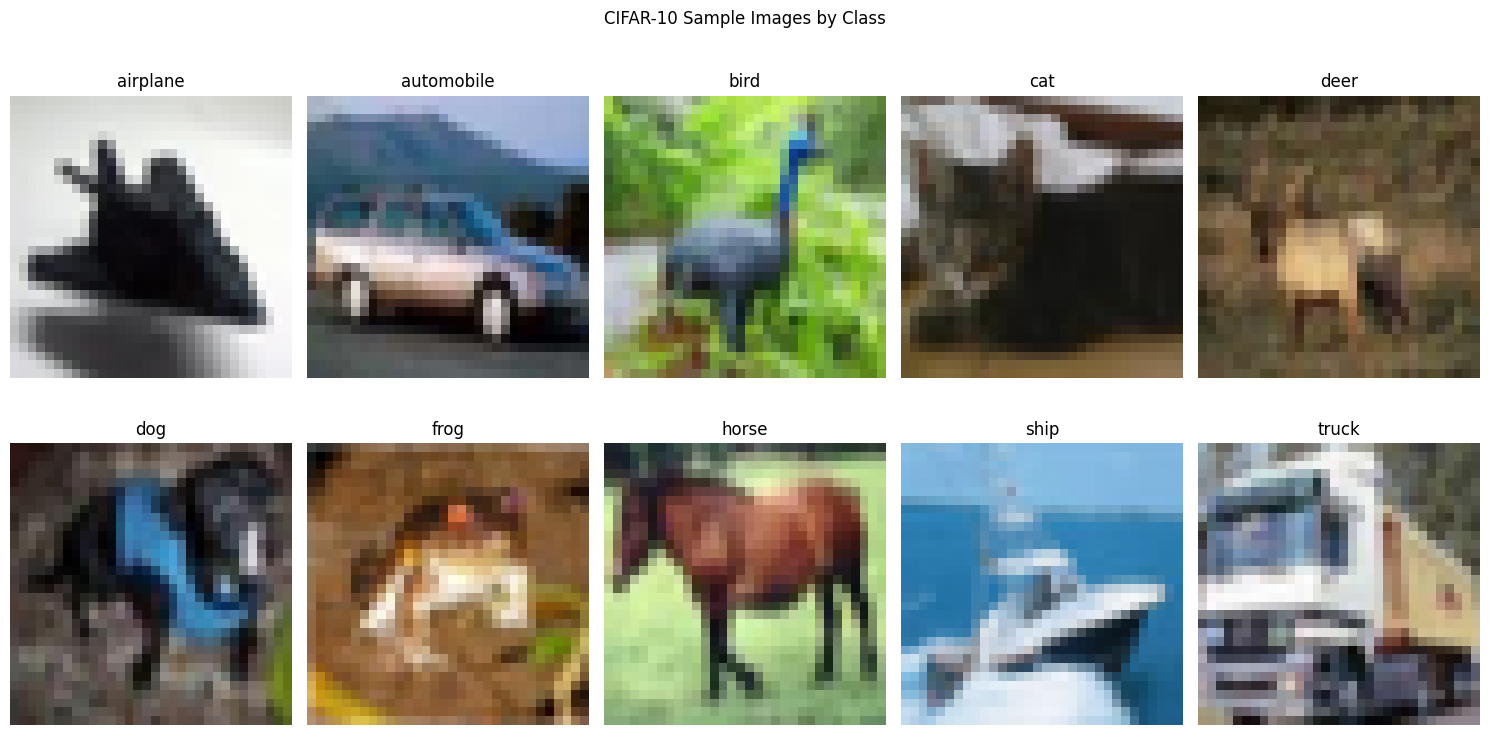

CIFAR-10 Dataset:
Training images: 50000
Image shape: (32, 32, 3)
Data type: uint8
Min pixel value: 0, Max pixel value: 255


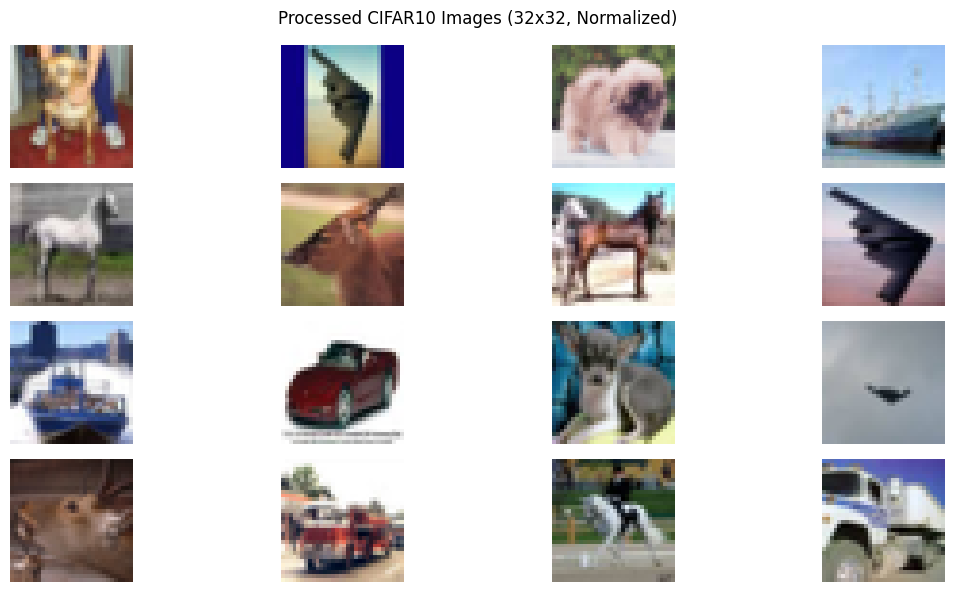

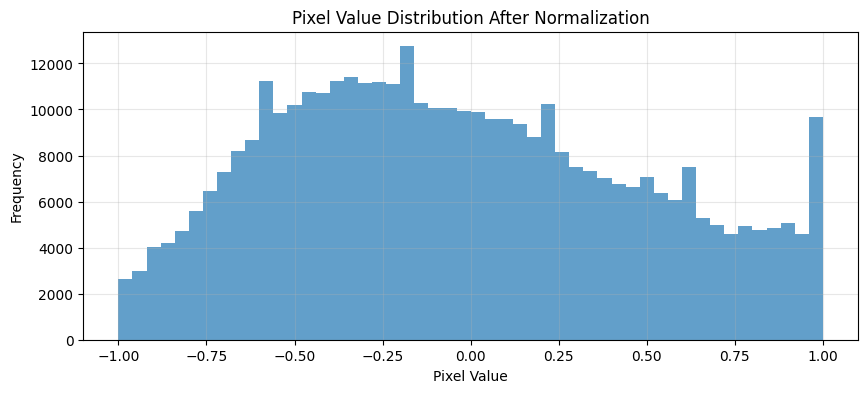

In [21]:
# Load and visualize the chosen dataset
dataset = DatasetFactory.create_dataset(config)

# Display a batch of processed images
for batch in dataset.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(min(16, batch.shape[0])):
        plt.subplot(4, 4, i+1)
        # Convert from [-1, 1] to [0, 1] for display
        img = (batch[i] + 1) / 2.0
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Processed {config.dataset.upper()} Images (32x32, Normalized)')
    plt.tight_layout()
    plt.show()

    # Show pixel value distribution after normalization
    flat_batch = tf.reshape(batch, [-1])
    plt.figure(figsize=(10, 4))
    plt.hist(flat_batch.numpy(), bins=50, alpha=0.7)
    plt.title('Pixel Value Distribution After Normalization')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

### 4. Generator Network
#### Our generator model takes random noise as input and outputs synthetic images. It uses transposed convolutions to progressively increase the spatial resolution.

In [22]:
class Generator(models.Model):
    """
    Generator network that transforms noise into images
    """
    def __init__(self, config):
        super(Generator, self).__init__()
        self.config = config
        self.z_dim = config.z_dim
        self.use_vbn = config.use_virtual_batch_norm

        # Initial dense layer to project noise
        self.initial_dense = layers.Dense(4 * 4 * 512)
        self.initial_reshape = layers.Reshape((4, 4, 512))

        # Batch normalization layers (create during init, not during call)
        self.initial_bn = layers.BatchNormalization()

        # Upsampling layers
        self.upsample_layers = []
        self.bn_layers = []  # Batch norm layers for each upsampling

        # Layer 1: 4x4 -> 8x8
        self.upsample_layers.append(self._make_upsample_block(512, 256))
        self.bn_layers.append(layers.BatchNormalization())

        # Layer 2: 8x8 -> 16x16
        self.upsample_layers.append(self._make_upsample_block(256, 128))
        self.bn_layers.append(layers.BatchNormalization())

        # Layer 3: 16x16 -> 32x32
        self.upsample_layers.append(self._make_upsample_block(128, 64))
        self.bn_layers.append(layers.BatchNormalization())

        # Final layer for 32x32 images
        if config.image_size == 32:
            self.final_conv = layers.Conv2DTranspose(
                config.channels,
                kernel_size=5,
                strides=1,
                padding='same',
                activation='tanh'
            )
        # Additional layer for 64x64 images
        elif config.image_size == 64:
            self.upsample_layers.append(self._make_upsample_block(64, 32))
            self.bn_layers.append(layers.BatchNormalization())
            self.final_conv = layers.Conv2DTranspose(
                config.channels,
                kernel_size=5,
                strides=1,
                padding='same',
                activation='tanh'
            )
        else:
            raise ValueError(f"Unsupported image size: {config.image_size}")

        # Set up VBN layers if used
        if self.use_vbn:
            self.vbn_layers = []
            # Add VBN after each layer
            for i in range(len(self.upsample_layers) + 1):  # +1 for initial dense
                self.vbn_layers.append(VirtualBatchNormalization())

    def _make_upsample_block(self, input_filters, output_filters):
        """Create an upsampling block"""
        return layers.Conv2DTranspose(
            output_filters,
            kernel_size=5,
            strides=2,
            padding='same'
        )

    def build(self, input_shape):
        # Call parent build
        super(Generator, self).build(input_shape)

        # Create a reference batch to set VBN statistics but defer actual call
        if self.use_vbn:
            self.reference_z = tf.random.normal([self.config.batch_size, self.z_dim])
            # Don't call self() here, let initialization occur in first actual forward pass
            self.vbn_initialized = False

    def call(self, inputs, training=True, set_reference=False):
        # Initialize VBN if needed
        if self.use_vbn and not hasattr(self, 'vbn_initialized'):
            set_reference = True
            self.vbn_initialized = True

        # Project and reshape noise vector
        x = self.initial_dense(inputs)
        x = self.initial_reshape(x)

        # Apply normalization
        if self.use_vbn:
            x = self.vbn_layers[0](x, set_reference=set_reference)
        else:
            x = self.initial_bn(x, training=training)

        x = layers.ReLU()(x)

        # Apply upsampling layers
        for i, up_layer in enumerate(self.upsample_layers):
            x = up_layer(x)

            # Apply normalization
            if self.use_vbn:
                x = self.vbn_layers[i+1](x, set_reference=set_reference)
            else:
                x = self.bn_layers[i](x, training=training)

            x = layers.ReLU()(x)

        # Apply final conv to get output
        x = self.final_conv(x)

        return x

### Create Generator and Visualize Architecture

Generator Model Summary:


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (1, 8192)                   │         827,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (1, 4, 4, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (1, 4, 4, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (1, 8, 8, 256)              │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (1, 8, 8, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (1, 16, 16, 128)            │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (1, 16, 16, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (1, 32, 32, 64)             │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (1, 32, 32, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (1, 32, 32, 3)              │           4,803 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,137,283 (19.60 MB)

 Trainable params: 5,135,363 (19.59 MB)

 Non-trainable params: 1,920 (7.50 KB)

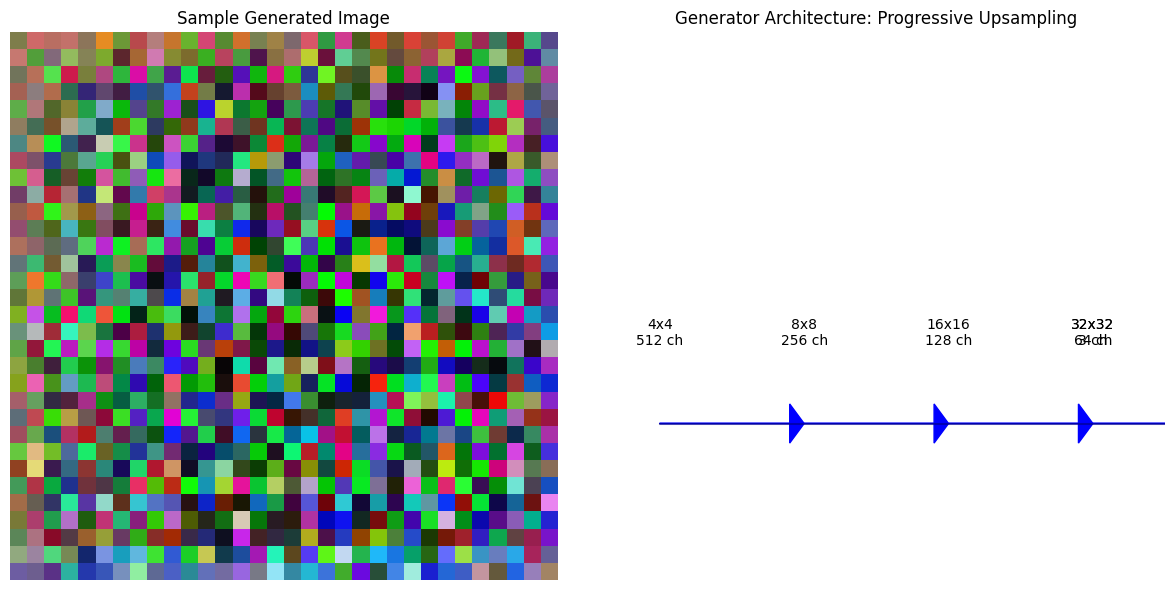

In [23]:
generator = Generator(config)
noise = tf.random.normal([1, config.z_dim])
generator_output = generator(noise)

print("Generator Model Summary:")
generator.summary()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

img = (generator_output[0] + 1) / 2.0
plt.imshow(img)
plt.title('Sample Generated Image')
plt.axis('off')
plt.subplot(1, 2, 2)
resolutions = ['4x4', '8x8', '16x16', '32x32']
channels = [512, 256, 128, 64, 3]
plt.plot([0, len(resolutions)], [0, 0], 'k-', alpha=0.3)

for i, (res, ch) in enumerate(zip(resolutions, channels[:-1])):
    plt.text(i, 0.1, f"{res}\n{ch} ch", ha='center')
    plt.arrow(i, 0, 0.9, 0, head_width=0.05, head_length=0.1, fc='blue', ec='blue')

plt.text(len(resolutions)-1, 0.1, f"{resolutions[-1]}\n{channels[-1]} ch", ha='center')
plt.ylim(-0.2, 0.5)
plt.xlim(-0.5, len(resolutions)-0.5)
plt.title('Generator Architecture: Progressive Upsampling')
plt.axis('off')
plt.tight_layout()
plt.show()

### 5. Discriminator Network
#### The discriminator takes images and classifies them as real or fake. It uses downsampling layers to progressively reduce the resolution.

In [24]:
class Discriminator(models.Model):
    """
    Discriminator network for classifying real vs fake images
    """
    def __init__(self, config):
        super(Discriminator, self).__init__()
        self.config = config
        self.image_size = config.image_size
        self.use_minibatch = config.use_minibatch_discrimination
        self.noise_layer = layers.GaussianNoise(0.2)
        self.downsample_layers = []
        self.downsample_layers.append(
            self._make_downsample_block(64, apply_batchnorm=False)
        )
        self.downsample_layers.append(
            self._make_downsample_block(128)
        )
        self.downsample_layers.append(
            self._make_downsample_block(256)
        )
        if config.image_size >= 64:
            self.downsample_layers.append(
                self._make_downsample_block(512)
            )
        self.flatten = layers.Flatten()
        self.feature_layer = layers.Dense(1024)
        self.feature_activation = layers.LeakyReLU(0.2)

        if self.use_minibatch:
            self.minibatch_layer = MinibatchDiscrimination(
                num_kernels=100,
                dim_per_kernel=5
            )
        self.output_layer = layers.Dense(1)

    def build(self, input_shape):
        super(Discriminator, self).build(input_shape)
        dummy_input = tf.zeros((1, *input_shape[1:]))
        for down_layer in self.downsample_layers:
            dummy_input = down_layer(dummy_input, training=False)
        dummy_input = self.flatten(dummy_input)
        flat_dim = dummy_input.shape[-1]
        self.feature_layer = layers.Dense(1024)

    def _make_downsample_block(self, filters, apply_batchnorm=True):
        """Create a downsampling block"""
        block = []
        block.append(layers.Conv2D(
            filters,
            kernel_size=5,
            strides=2,
            padding='same'
        ))

        if apply_batchnorm:
            block.append(layers.BatchNormalization())

        # Activation
        block.append(layers.LeakyReLU(0.2))

        # Optional dropout for more complex networks
        if filters >= 256:
            block.append(layers.Dropout(0.3))

        return tf.keras.Sequential(block)

    def call(self, inputs, training=True, return_features=False):
        # Add noise to inputs during training (stabilizes)
        if training:
            x = self.noise_layer(inputs)
        else:
            x = inputs

        # Apply downsampling layers
        for down_layer in self.downsample_layers:
            x = down_layer(x, training=training)

        # Flatten
        x = self.flatten(x)

        # Feature layer
        features = self.feature_layer(x)
        features = self.feature_activation(features)

        # Apply minibatch discrimination if used
        if self.use_minibatch:
            discriminator_features = self.minibatch_layer(features)
        else:
            discriminator_features = features

        # Output layer
        output = self.output_layer(discriminator_features)

        if return_features:
            return output, features
        else:
            return output

### Create Discriminator and Visualize Architecture

Discriminator Model Summary:


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (1, 16, 16, 64)             │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (1, 8, 8, 128)              │         205,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (1, 4, 4, 256)              │         820,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 4096)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ minibatch_discrimination_1           │ ?                           │         512,000 │
│ (MinibatchDiscrimination)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 1)                      │           1,125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 1024)                   │       4,195,328 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,739,237 (21.89 MB)

 Trainable params: 5,738,469 (21.89 MB)

 Non-trainable params: 768 (3.00 KB)

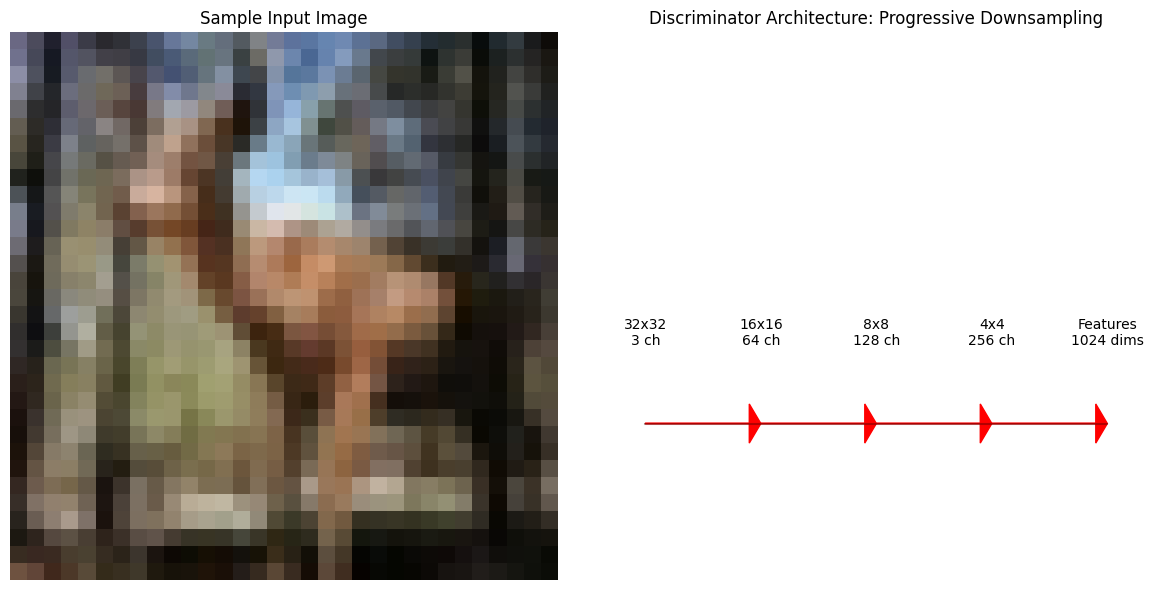

In [25]:
# Create discriminator instance and visualize architecture
discriminator = Discriminator(config)
# Generate a sample batch to visualize
sample_images = next(iter(dataset))[:1]
# Force model build
_ = discriminator(sample_images)

print("Discriminator Model Summary:")
discriminator.summary()

# Visualize the discriminator architecture
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
# Plot sample input image
img = (sample_images[0] + 1) / 2.0
plt.imshow(img)
plt.title('Sample Input Image')
plt.axis('off')

# Show the downsampling process
plt.subplot(1, 2, 2)
resolutions = ['32x32', '16x16', '8x8', '4x4', 'Features']
channels = [3, 64, 128, 256, 1024]
plt.plot([0, len(resolutions)-1], [0, 0], 'k-', alpha=0.3)  # Base line
for i, (res, ch) in enumerate(zip(resolutions[:-1], channels[:-1])):
    plt.text(i, 0.1, f"{res}\n{ch} ch", ha='center')
    plt.arrow(i, 0, 0.9, 0, head_width=0.05, head_length=0.1, fc='red', ec='red')
plt.text(len(resolutions)-1, 0.1, f"{resolutions[-1]}\n{channels[-1]} dims", ha='center')
plt.ylim(-0.2, 0.5)
plt.xlim(-0.5, len(resolutions)-0.5)
plt.title('Discriminator Architecture: Progressive Downsampling')
plt.axis('off')
plt.tight_layout()
plt.show()

### 6. Full GAN Implementation with Improved Techniques
#### Now we'll implement the complete Improved GAN by combining all the techniques we've implemented: feature matching, minibatch discrimination, virtual batch normalization, and historical averaging.

In [26]:
class ImprovedGAN:
    """
    Implementation of Improved GAN from Salimans et al. (2016)
    Features:
    - Feature Matching
    - Minibatch Discrimination
    - Virtual Batch Normalization (optional)
    - Historical Averaging
    - One-sided Label Smoothing
    """

    def __init__(self, config):
        self.config = config

        # Create generator and discriminator
        self.generator = Generator(config)
        self.discriminator = Discriminator(config)

        # Set up losses
        self.feature_matching = FeatureMatching()
        self.historical_averaging = HistoricalAveraging(beta=0.99)

        # Set up optimizers
        self.gen_optimizer = tf.keras.optimizers.Adam(
            learning_rate=config.learning_rate_g,
            beta_1=config.beta1,
            beta_2=config.beta2
        )
        self.disc_optimizer = tf.keras.optimizers.Adam(
            learning_rate=config.learning_rate_d,
            beta_1=config.beta1,
            beta_2=config.beta2
        )

        # Create directories for samples and checkpoints
        os.makedirs(config.sample_dir, exist_ok=True)
        os.makedirs(config.checkpoint_dir, exist_ok=True)

        # Fixed noise for consistent evaluation
        self.fixed_noise = tf.random.normal([16, config.z_dim])

        # Track losses and metrics for plotting
        self.gen_losses = []
        self.disc_losses = []
        self.real_scores = []
        self.fake_scores = []
        self.real_accs = []
        self.fake_accs = []

    def generator_loss(self, fake_output, real_features=None, fake_features=None):
        """Calculate generator loss with feature matching"""
        # One-sided label smoothing
        target = tf.ones_like(fake_output) * self.config.generator_target_prob

        # Primary adversarial loss
        gen_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(
                target, fake_output, from_logits=True
            )
        )

        # Add feature matching loss if enabled and features are provided
        if self.config.use_feature_matching and real_features is not None and fake_features is not None:
            fm_loss = self.feature_matching(real_features, fake_features)
            gen_loss += self.config.feature_matching_weight * fm_loss

        # Add historical averaging if enabled
        if self.config.use_historical_averaging:
            ha_loss = self.historical_averaging(self.generator, self.config.historical_averaging_weight)
            gen_loss += ha_loss

        return gen_loss

    def discriminator_loss(self, real_output, fake_output):
        """Calculate discriminator loss with one-sided label smoothing"""
        # One-sided label smoothing for real samples
        real_labels = tf.ones_like(real_output) * (1.0 - self.config.label_smoothing)
        fake_labels = tf.zeros_like(fake_output)

        # Calculate losses
        real_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(
                real_labels, real_output, from_logits=True
            )
        )
        fake_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(
                fake_labels, fake_output, from_logits=True
            )
        )

        disc_loss = real_loss + fake_loss

        # Add historical averaging if enabled
        if self.config.use_historical_averaging:
            ha_loss = self.historical_averaging(self.discriminator, self.config.historical_averaging_weight)
            disc_loss += ha_loss

        return disc_loss

    @tf.function
    def train_step(self, real_images):
        """Single training step for GAN"""
        batch_size = tf.shape(real_images)[0]

        # Generate random noise
        noise = tf.random.normal([batch_size, self.config.z_dim])

        # Train discriminator
        with tf.GradientTape() as disc_tape:
            # Generate fake images
            fake_images = self.generator(noise, training=True)

            # Get discriminator outputs
            real_output, real_features = self.discriminator(real_images, training=True, return_features=True)
            fake_output, fake_features = self.discriminator(fake_images, training=True, return_features=True)

            # Calculate discriminator loss
            disc_loss = self.discriminator_loss(real_output, fake_output)

        # Apply discriminator gradients
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        # UPDATE: Add explicit call to update history for discriminator (outside of tf.function)
        tf.py_function(
            func=lambda: self.historical_averaging.update_history(self.discriminator),
            inp=[],
            Tout=[]
        )

        # Train generator (multiple steps if configured)
        gen_loss = 0.0
        for _ in range(self.config.generator_steps):
            noise = tf.random.normal([batch_size, self.config.z_dim])

            with tf.GradientTape() as gen_tape:
                # Generate fake images
                fake_images = self.generator(noise, training=True)

                # Get discriminator output
                fake_output, fake_features = self.discriminator(fake_images, training=True, return_features=True)

                # Calculate generator loss
                curr_gen_loss = self.generator_loss(fake_output, real_features, fake_features)
                gen_loss += curr_gen_loss

            # Apply generator gradients
            gen_gradients = gen_tape.gradient(curr_gen_loss, self.generator.trainable_variables)
            self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

            # UPDATE: Add explicit call to update history for generator (outside of tf.function)
            tf.py_function(
                func=lambda: self.historical_averaging.update_history(self.generator),
                inp=[],
                Tout=[]
            )
        # Calculate metrics
        gen_loss = gen_loss / self.config.generator_steps

        # Calculate discriminator accuracy
        real_sigmoid = tf.sigmoid(real_output)
        fake_sigmoid = tf.sigmoid(fake_output)
        real_acc = tf.reduce_mean(tf.cast(real_sigmoid > 0.5, tf.float32))
        fake_acc = tf.reduce_mean(tf.cast(fake_sigmoid < 0.5, tf.float32))

        # Track raw scores for monitoring
        real_score = tf.reduce_mean(real_sigmoid)
        fake_score = tf.reduce_mean(fake_sigmoid)

        return {
            "gen_loss": gen_loss,
            "disc_loss": disc_loss,
            "real_score": real_score,
            "fake_score": fake_score,
            "real_acc": real_acc,
            "fake_acc": fake_acc
        }

    def train(self, dataset, epochs):
        """Train the GAN for multiple epochs"""
        start_time = time.time()

        # Initialize historical averaging if used
        if self.config.use_historical_averaging:
            self.historical_averaging.initialize_if_needed(self.generator)
            self.historical_averaging.initialize_if_needed(self.discriminator)

        for epoch in range(epochs):
            epoch_start = time.time()

            # Setup progress bar
            progress_bar = tqdm(total=len(list(dataset)))
            progress_bar.set_description(f"Epoch {epoch+1}/{epochs}")

            # Track epoch metrics
            epoch_gen_losses = []
            epoch_disc_losses = []
            epoch_real_scores = []
            epoch_fake_scores = []
            epoch_real_accs = []
            epoch_fake_accs = []

            # Train on batches
            for batch in dataset:
                metrics = self.train_step(batch)

                # Update historical averaging after each step (outside of tf.function)
                if self.config.use_historical_averaging:
                    self.historical_averaging.update_history(self.generator)
                    self.historical_averaging.update_history(self.discriminator)

                # Track metrics
                epoch_gen_losses.append(metrics["gen_loss"].numpy())
                epoch_disc_losses.append(metrics["disc_loss"].numpy())
                epoch_real_scores.append(metrics["real_score"].numpy())
                epoch_fake_scores.append(metrics["fake_score"].numpy())
                epoch_real_accs.append(metrics["real_acc"].numpy())
                epoch_fake_accs.append(metrics["fake_acc"].numpy())

                # Update progress bar
                progress_bar.update(1)
                desc = f"Epoch {epoch+1}/{epochs} - "
                desc += f"G: {metrics['gen_loss']:.4f}, D: {metrics['disc_loss']:.4f}, "
                desc += f"D(x): {metrics['real_score']:.4f}, D(G(z)): {metrics['fake_score']:.4f}"
                progress_bar.set_description(desc)

            progress_bar.close()

            # Calculate epoch averages
            avg_gen_loss = np.mean(epoch_gen_losses)
            avg_disc_loss = np.mean(epoch_disc_losses)
            avg_real_score = np.mean(epoch_real_scores)
            avg_fake_score = np.mean(epoch_fake_scores)
            avg_real_acc = np.mean(epoch_real_accs)
            avg_fake_acc = np.mean(epoch_fake_accs)

            # Track for plotting
            self.gen_losses.append(avg_gen_loss)
            self.disc_losses.append(avg_disc_loss)
            self.real_scores.append(avg_real_score)
            self.fake_scores.append(avg_fake_score)
            self.real_accs.append(avg_real_acc)
            self.fake_accs.append(avg_fake_acc)

            # Generate and save sample images
            if (epoch + 1) % self.config.sample_freq == 0:
                self.generate_and_save_images(epoch + 1)

            # Save checkpoint if configured
            if (epoch + 1) % self.config.save_freq == 0:
                self.save_checkpoint(epoch + 1)

            epoch_time = time.time() - epoch_start
            print(f"Epoch {epoch+1}/{epochs} completed in {epoch_time:.2f}s")
            print(f"Generator Loss: {avg_gen_loss:.4f}")
            print(f"Discriminator Loss: {avg_disc_loss:.4f}")
            print(f"D(x): {avg_real_score:.4f}, D(G(z)): {avg_fake_score:.4f}")
            print(f"Real Acc: {avg_real_acc:.4f}, Fake Acc: {avg_fake_acc:.4f}")
            print("-" * 80)

        total_time = time.time() - start_time
        print(f"Training completed in {total_time/60:.2f} minutes")

        # Plot training progress
        self.plot_training_history()

    def generate_and_save_images(self, epoch):
        """Generate and save images for visualization"""
        # Generate images from fixed noise
        predictions = self.generator(self.fixed_noise, training=False)

        # Create a grid of images
        fig = plt.figure(figsize=(8, 8))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            # Convert from [-1, 1] to [0, 1]
            img = (predictions[i].numpy() + 1) / 2.0
            plt.imshow(img)
            plt.axis("off")

        plt.suptitle(f"Generated Images - Epoch {epoch}")
        plt.tight_layout()
        plt.savefig(f"{self.config.sample_dir}/epoch_{epoch}.png")
        plt.close()

    def plot_training_history(self):
        """Plot training metrics"""
        epochs = range(1, len(self.gen_losses) + 1)

        plt.figure(figsize=(15, 10))

        # Plot losses
        plt.subplot(2, 2, 1)
        plt.plot(epochs, self.gen_losses, label='Generator Loss')
        plt.plot(epochs, self.disc_losses, label='Discriminator Loss')
        plt.title('Generator and Discriminator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot discriminator scores
        plt.subplot(2, 2, 2)
        plt.plot(epochs, self.real_scores, label='D(x) - Real Scores')
        plt.plot(epochs, self.fake_scores, label='D(G(z)) - Fake Scores')
        plt.title('Discriminator Scores')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot accuracies
        plt.subplot(2, 2, 3)
        plt.plot(epochs, self.real_accs, label='Real Accuracy')
        plt.plot(epochs, self.fake_accs, label='Fake Accuracy')
        plt.title('Discriminator Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Generate final images
        plt.subplot(2, 2, 4)
        predictions = self.generator(self.fixed_noise, training=False)

        # Display a 4x4 grid from the last 16 images
        grid_size = 4
        fig_embedded = plt.figure(figsize=(4, 4))
        for i in range(min(16, predictions.shape[0])):
            plt.subplot(grid_size, grid_size, i+1)
            img = (predictions[i].numpy() + 1) / 2.0
            plt.imshow(img)
            plt.axis('off')
        plt.tight_layout()
        plt.title('Final Generated Images')

        plt.suptitle('GAN Training Progress', fontsize=16)
        plt.tight_layout()
        plt.savefig(f"{self.config.log_dir}/training_history.png")
        plt.show()

    def save_checkpoint(self, epoch):
        checkpoint_dir = os.path.join(self.config.checkpoint_dir, f"checkpoint_epoch_{epoch}")
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Save generator
        self.generator.save_weights(os.path.join(checkpoint_dir, "generator.weights.h5"))

        # Save discriminator
        self.discriminator.save_weights(os.path.join(checkpoint_dir, "discriminator.weights.h5"))

    def load_checkpoint(self, epoch):
        """Load model from checkpoint"""
        checkpoint_dir = os.path.join(self.config.checkpoint_dir, f"checkpoint_epoch_{epoch}")

        # Load generator
        self.generator.load_weights(os.path.join(checkpoint_dir, "generator.weights.h5"))

        # Load discriminator
        self.discriminator.load_weights(os.path.join(checkpoint_dir, "discriminator.weights.h5"))

        print(f"Checkpoint loaded from epoch {epoch}")

### 7. FID Score Implementation for GAN Evaluation
#### The Fréchet Inception Distance (FID) is a metric that measures the similarity between two datasets of images. It's commonly used to evaluate the quality of images generated by GANs.

In [27]:
class FIDEvaluator:
    """
    Evaluates GAN performance using Fréchet Inception Distance (FID).
    FID measures the similarity between generated and real image distributions
    using features extracted from a pre-trained InceptionV3 model.
    """

    def __init__(self, config):
        """
        Initialize the FID evaluator with the given configuration.

        Args:
            config: GANConfig object with settings for evaluation
        """
        self.config = config
        self.batch_size = config.batch_size

        # Load InceptionV3 model for feature extraction
        # Using the final pool layer as feature extractor
        self.inception_model = tf.keras.applications.InceptionV3(
            include_top=False,
            pooling='avg',
            weights='imagenet',
            input_shape=(299, 299, 3)
        )

        # Cache for real data statistics
        self.real_features = None
        self.real_mean = None
        self.real_cov = None

        print("FID Evaluator initialized")

    def preprocess_images(self, images):
        """
        Prepare images for the Inception model.

        Args:
            images: Tensor of images in [-1, 1] range

        Returns:
            Preprocessed images ready for InceptionV3
        """
        # Convert from [-1, 1] to [0, 1] range
        images = (images + 1) / 2.0

        # Resize to Inception input size
        images = tf.image.resize(images, (299, 299))

        # Preprocess for Inception
        images = tf.keras.applications.inception_v3.preprocess_input(images * 255.0)

        return images

    def extract_features(self, images):
        """
        Extract features from images using InceptionV3.

        Args:
            images: Batch of preprocessed images

        Returns:
            Feature vectors
        """
        features = self.inception_model.predict(images, batch_size=self.batch_size)
        return features

    def compute_real_statistics(self, dataset, num_samples=10000):
        """
        Compute statistics for real image dataset.

        Args:
            dataset: TensorFlow dataset of real images
            num_samples: Number of samples to use (default: 10000)

        Returns:
            Tuple of (mean, covariance) of the real features
        """
        print(f"Computing real data statistics using {num_samples} samples...")

        # Extract images from dataset
        real_images = []
        for batch in dataset:
            for img in batch:
                real_images.append(img.numpy())
            if len(real_images) >= num_samples:
                break

        # Ensure we have exactly num_samples
        real_images = np.array(real_images[:num_samples])

        # Preprocess images for Inception
        processed_images = self.preprocess_images(real_images)

        # Extract features in batches to avoid memory issues
        features = []
        batch_size = self.batch_size
        for i in range(0, len(processed_images), batch_size):
            batch = processed_images[i:i+batch_size]
            batch_features = self.extract_features(batch)
            features.append(batch_features)

        self.real_features = np.concatenate(features, axis=0)

        # Calculate statistics
        self.real_mean = np.mean(self.real_features, axis=0)
        self.real_cov = np.cov(self.real_features, rowvar=False)

        print(f"Real data statistics calculated from {len(self.real_features)} images")

        return self.real_mean, self.real_cov

    def calculate_fid(self, generator, num_samples=10000):
        """
        Calculate FID score between real images and generated images.

        Args:
            generator: Generator model
            num_samples: Number of samples to use (default: 10000)

        Returns:
            FID score (lower is better)
        """
        if self.real_mean is None or self.real_cov is None:
            raise ValueError("Real statistics not computed. Run compute_real_statistics first.")

        print(f"Calculating FID score using {num_samples} generated samples...")

        # Generate images
        z_dim = self.config.z_dim
        batch_size = self.batch_size
        num_batches = int(np.ceil(num_samples / batch_size))

        fake_images = []
        for i in range(num_batches):
            current_batch_size = min(batch_size, num_samples - i * batch_size)
            z = tf.random.normal([current_batch_size, z_dim])
            generated_batch = generator(z, training=False)
            fake_images.append(generated_batch)

        fake_images = np.concatenate(fake_images, axis=0)[:num_samples]

        # Preprocess and extract features
        processed_images = self.preprocess_images(fake_images)

        # Extract features in batches
        fake_features = []
        for i in range(0, len(processed_images), batch_size):
            batch = processed_images[i:i+batch_size]
            batch_features = self.extract_features(batch)
            fake_features.append(batch_features)

        fake_features = np.concatenate(fake_features, axis=0)

        # Calculate statistics
        fake_mean = np.mean(fake_features, axis=0)
        fake_cov = np.cov(fake_features, rowvar=False)

        # Calculate FID: ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2))
        from scipy import linalg

        # Calculate mean difference term
        mean_diff_squared = np.sum((self.real_mean - fake_mean) ** 2)

        # Calculate covariance term
        # First compute sqrt(C_1*C_2) which can be numerically unstable
        covmean = linalg.sqrtm(self.real_cov.dot(fake_cov))

        # Ensure the result is real
        if np.iscomplexobj(covmean):
            covmean = covmean.real

        # Compute the FID
        fid = mean_diff_squared + np.trace(self.real_cov + fake_cov - 2 * covmean)

        print(f"FID Score: {fid:.4f} (lower is better)")

        return fid

    def evaluate_with_samples(self, real_images, fake_images, num_samples=10000):
        """
        Calculate FID directly from image samples.
        Useful for external evaluation.

        Args:
            real_images: numpy array of real images [-1, 1]
            fake_images: numpy array of generated images [-1, 1]
            num_samples: number of samples to use for evaluation

        Returns:
            FID score
        """
        # Ensure we have exactly num_samples
        real_samples = real_images[:num_samples]
        fake_samples = fake_images[:num_samples]

        # Preprocess images
        processed_real = self.preprocess_images(real_samples)
        processed_fake = self.preprocess_images(fake_samples)

        # Extract features
        batch_size = self.batch_size

        # Real features
        real_features = []
        for i in range(0, len(processed_real), batch_size):
            batch = processed_real[i:i+batch_size]
            batch_features = self.extract_features(batch)
            real_features.append(batch_features)
        real_features = np.concatenate(real_features, axis=0)

        # Fake features
        fake_features = []
        for i in range(0, len(processed_fake), batch_size):
            batch = processed_fake[i:i+batch_size]
            batch_features = self.extract_features(batch)
            fake_features.append(batch_features)
        fake_features = np.concatenate(fake_features, axis=0)

        # Calculate statistics
        real_mean = np.mean(real_features, axis=0)
        real_cov = np.cov(real_features, rowvar=False)

        fake_mean = np.mean(fake_features, axis=0)
        fake_cov = np.cov(fake_features, rowvar=False)

        # Calculate FID
        from scipy import linalg

        mean_diff_squared = np.sum((real_mean - fake_mean) ** 2)
        covmean = linalg.sqrtm(real_cov.dot(fake_cov))

        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = mean_diff_squared + np.trace(real_cov + fake_cov - 2 * covmean)

        print(f"FID Score: {fid:.4f} (lower is better)")

        return fid

### 8. Experimental Runner
#### Let's implement a simple experiment runner to train and evaluate our improved GAN:

In [28]:
def run_gan_experiment(config, dataset, epochs=10, evaluate_every=5):
    """
    Run a GAN experiment with the specified configuration,
    training for a number of epochs and evaluating periodically.

    Args:
        config: GANConfig object
        dataset: TensorFlow dataset
        epochs: Number of epochs to train
        evaluate_every: Evaluate FID every this many epochs

    Returns:
        Trained GAN model and evaluation results
    """
    print("=== Starting GAN Experiment ===")
    print(f"Configuration: {config}")
    print(f"Training for {epochs} epochs, evaluating every {evaluate_every} epochs")

    # Initialize FID evaluator
    fid_evaluator = FIDEvaluator(config)

    # Compute real statistics for FID (do this once)
    fid_evaluator.compute_real_statistics(dataset, num_samples=1000)  # Using fewer samples for speed

    # Create GAN
    gan = ImprovedGAN(config)

    # Record FID scores
    fid_scores = []

    # Train for specified epochs
    for epoch in range(epochs):
        print(f"\n=== Epoch {epoch+1}/{epochs} ===")

        # Create a single-epoch dataset to train for just this epoch
        epoch_dataset = dataset

        # Train for one epoch
        gan.train(epoch_dataset, 1)  # One epoch at a time

        # Evaluate FID if scheduled
        if (epoch + 1) % evaluate_every == 0 or epoch == epochs - 1:
            print(f"Evaluating FID after epoch {epoch+1}")
            fid = fid_evaluator.calculate_fid(gan.generator, num_samples=1000)  # Using fewer samples for speed
            fid_scores.append((epoch + 1, fid))

    # Final evaluation
    print("\n=== Final Evaluation ===")
    final_fid = fid_evaluator.calculate_fid(gan.generator, num_samples=2000)

    # Plot FID scores over time if available
    if len(fid_scores) > 0:
        plt.figure(figsize=(10, 6))
        epochs, scores = zip(*fid_scores)
        plt.plot(epochs, scores, 'o-', linewidth=2)
        plt.title('FID Score Over Training (Lower is Better)')
        plt.xlabel('Epochs')
        plt.ylabel('FID Score')
        plt.grid(True, alpha=0.3)
        plt.savefig(f"{config.log_dir}/fid_history.png")
        plt.show()

    # Generate a final grid of samples
    final_samples = 36
    noise = tf.random.normal([final_samples, config.z_dim])
    generated_images = gan.generator(noise, training=False)

    # Plot the samples
    plt.figure(figsize=(10, 10))
    for i in range(final_samples):
        plt.subplot(6, 6, i+1)
        img = (generated_images[i].numpy() + 1) / 2.0
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Final Generated Samples (FID: {final_fid:.4f})')
    plt.tight_layout()
    plt.savefig(f"{config.log_dir}/final_samples.png")
    plt.show()

    return gan, fid_scores, final_fid

### 9. Comparative Analysis of GAN Improvements
#### Now let's implement a function to compare the effectiveness of different GAN improvements:

In [29]:
def compare_gan_improvements(dataset, base_epochs=5):
    """
    Compare various GAN improvements by training and evaluating
    different configurations.

    Args:
        dataset: TensorFlow dataset to use for training
        base_epochs: Number of epochs to train each configuration

    Returns:
        Dictionary of results for each configuration
    """
    print("=== GAN Improvement Comparison Study ===")

    # Define configurations to test
    configs = [
        # 1. Baseline (no improvements)
        {
            "name": "baseline",
            "updates": {
                "use_feature_matching": False,
                "use_minibatch_discrimination": False,
                "use_historical_averaging": False,
                "label_smoothing": 0.0
            }
        },
        # 2. With Feature Matching only
        {
            "name": "feature_matching",
            "updates": {
                "use_feature_matching": True,
                "use_minibatch_discrimination": False,
                "use_historical_averaging": False,
                "label_smoothing": 0.0
            }
        },
        # 3. With Minibatch Discrimination only
        {
            "name": "minibatch_disc",
            "updates": {
                "use_feature_matching": False,
                "use_minibatch_discrimination": True,
                "use_historical_averaging": False,
                "label_smoothing": 0.0
            }
        },
        # 4. With Historical Averaging only
        {
            "name": "historical_avg",
            "updates": {
                "use_feature_matching": False,
                "use_minibatch_discrimination": False,
                "use_historical_averaging": True,
                "label_smoothing": 0.0
            }
        },
        # 5. With Label Smoothing only
        {
            "name": "label_smoothing",
            "updates": {
                "use_feature_matching": False,
                "use_minibatch_discrimination": False,
                "use_historical_averaging": False,
                "label_smoothing": 0.25
            }
        },
        # 6. All improvements
        {
            "name": "all_improvements",
            "updates": {
                "use_feature_matching": True,
                "use_minibatch_discrimination": True,
                "use_historical_averaging": True,
                "label_smoothing": 0.25
            }
        }
    ]

    # Initialize FID evaluator once for consistency
    base_config = GANConfig()
    fid_evaluator = FIDEvaluator(base_config)
    fid_evaluator.compute_real_statistics(dataset, num_samples=1000)

    # Train each configuration and record results
    results = {}

    for config_info in configs:
        name = config_info["name"]
        updates = config_info["updates"]

        print(f"\n\n=== Training Configuration: {name} ===")
        print("Settings:")
        for k, v in updates.items():
            print(f"  {k}: {v}")

        # Create config with updates
        config = GANConfig()
        for k, v in updates.items():
            setattr(config, k, v)

        # Set up output directories
        config.sample_dir = f"samples/{name}"
        config.checkpoint_dir = f"checkpoints/{name}"
        config.log_dir = f"logs/{name}"

        # Create directories
        os.makedirs(config.sample_dir, exist_ok=True)
        os.makedirs(config.checkpoint_dir, exist_ok=True)
        os.makedirs(config.log_dir, exist_ok=True)

        # Train GAN
        gan = ImprovedGAN(config)
        gan.train(dataset, base_epochs)

        # Evaluate FID
        fid_score = fid_evaluator.calculate_fid(gan.generator, num_samples=1000)

        # Store results
        results[name] = {
            "gan": gan,
            "config": config,
            "fid": fid_score,
            "gen_loss": gan.gen_losses[-1] if len(gan.gen_losses) > 0 else None,
            "disc_loss": gan.disc_losses[-1] if len(gan.disc_losses) > 0 else None,
            "real_score": gan.real_scores[-1] if len(gan.real_scores) > 0 else None,
            "fake_score": gan.fake_scores[-1] if len(gan.fake_scores) > 0 else None
        }

        # Save results to file for later analysis
        np.savez(
            f"{config.log_dir}/metrics.npz",
            gen_losses=np.array(gan.gen_losses),
            disc_losses=np.array(gan.disc_losses),
            real_scores=np.array(gan.real_scores),
            fake_scores=np.array(gan.fake_scores),
            real_accs=np.array(gan.real_accs),
            fake_accs=np.array(gan.fake_accs),
            fid=np.array([fid_score])
        )

    # Create comparison visualizations
    visualize_comparison_results(results)

    return results

### 10. Visualization of Comparative Results
#### Now let's implement comprehensive visualizations to compare the different GAN improvement techniques:

In [35]:
def visualize_comparison_results(results):
    """
    Create visualizations comparing different GAN improvement techniques.

    Args:
        results: Dictionary of results from compare_gan_improvements
    """
    print("Creating comparative visualizations...")

    # Define colors for consistent visualization
    colors = {
        'baseline': 'gray',
        'feature_matching': 'blue',
        'minibatch_disc': 'green',
        'historical_avg': 'purple',
        'label_smoothing': 'orange',
        'all_improvements': 'red'
    }

    # 1. FID Score Comparison
    plt.figure(figsize=(12, 6))
    names = []
    fid_scores = []

    for name, result in results.items():
        names.append(name)
        fid_scores.append(result["fid"])

    # Sort by FID (lower is better)
    sorted_indices = np.argsort(fid_scores)
    sorted_names = [names[i] for i in sorted_indices]
    sorted_fids = [fid_scores[i] for i in sorted_indices]
    sorted_colors = [colors[name] for name in sorted_names]

    plt.barh(sorted_names, sorted_fids, color=sorted_colors)
    plt.title('FID Score Comparison (Lower is Better)')
    plt.xlabel('FID Score')
    plt.grid(axis='x', alpha=0.3)

    # Add values as text
    for i, v in enumerate(sorted_fids):
        plt.text(v + 0.5, i, f"{v:.2f}", va='center')

    plt.tight_layout()
    plt.savefig("fid_comparison.png", dpi=150)
    plt.show()

    # 2. Training Loss Comparison
    plt.figure(figsize=(15, 6))

    # Generator Loss
    plt.subplot(1, 2, 1)
    for name, result in results.items():
        if "gan" in result and hasattr(result["gan"], "gen_losses"):
            plt.plot(result["gan"].gen_losses, label=name, color=colors[name], linewidth=2)

    plt.title('Generator Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Discriminator Loss
    plt.subplot(1, 2, 2)
    for name, result in results.items():
        if "gan" in result and hasattr(result["gan"], "disc_losses"):
            plt.plot(result["gan"].disc_losses, label=name, color=colors[name], linewidth=2)

    plt.title('Discriminator Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.suptitle('Training Loss Comparison Across Techniques', fontsize=16)
    plt.tight_layout()
    plt.savefig("loss_comparison.png", dpi=150)
    plt.show()

    # 3. Discriminator Score Comparison
    plt.figure(figsize=(15, 6))

    # Real Scores
    plt.subplot(1, 2, 1)
    for name, result in results.items():
        if "gan" in result and hasattr(result["gan"], "real_scores"):
            plt.plot(result["gan"].real_scores, label=name, color=colors[name], linewidth=2)

    plt.title('D(x) - Real Score Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Fake Scores
    plt.subplot(1, 2, 2)
    for name, result in results.items():
        if "gan" in result and hasattr(result["gan"], "fake_scores"):
            plt.plot(result["gan"].fake_scores, label=name, color=colors[name], linewidth=2)

    plt.title('D(G(z)) - Fake Score Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.suptitle('Discriminator Score Comparison', fontsize=16)
    plt.tight_layout()
    plt.savefig("score_comparison.png", dpi=150)
    plt.show()

    # 4. Sample Images Comparison - Simplified version that won't cause GridSpec issues
    # Number of configurations to show
    configs_to_show = min(6, len(results))

    # Use fixed noise for fair comparison
    fixed_noise = tf.random.normal([16, 100])  # z_dim=100

    # Create separate figures for each configuration to avoid GridSpec issues
    for name, result in list(results.items())[:configs_to_show]:
        plt.figure(figsize=(8, 8))
        plt.suptitle(f"{name.replace('_', ' ').title()} (FID: {result['fid']:.2f})", fontsize=14)

        # Generate images with the same noise
        generated_images = result["gan"].generator(fixed_noise, training=False)

        # Create a grid of 4x4 images
        for j in range(16):
            plt.subplot(4, 4, j+1)
            img = (generated_images[j].numpy() + 1) / 2.0
            plt.imshow(img)
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(f"samples_{name}.png", dpi=150)
        plt.show()

    # 5. Create a summary table
    print("\nSummary of Results:")
    print("-" * 100)
    print(f"{'Configuration':<20} {'FID Score':<12} {'Gen Loss':<12} {'Disc Loss':<12} {'D(x)':<12} {'D(G(z))':<12}")
    print("-" * 100)

    # Sort by FID
    sorted_results = sorted(results.items(), key=lambda x: x[1]["fid"])

    for name, result in sorted_results:
        print(f"{name:<20} {result['fid']:<12.4f} ", end="")

        if result["gen_loss"] is not None:
            print(f"{result['gen_loss']:<12.4f} ", end="")
        else:
            print(f"{'N/A':<12} ", end="")

        if result["disc_loss"] is not None:
            print(f"{result['disc_loss']:<12.4f} ", end="")
        else:
            print(f"{'N/A':<12} ", end="")

        if result["real_score"] is not None:
            print(f"{result['real_score']:<12.4f} ", end="")
        else:
            print(f"{'N/A':<12} ", end="")

        if result["fake_score"] is not None:
            print(f"{result['fake_score']:<12.4f}")
        else:
            print(f"{'N/A':<12}")

    print("-" * 100)

### 11. Mode Collapse Analysis
#### Let's implement additional tools to analyze mode collapse, which is a common issue in GANs:

In [31]:
def analyze_mode_collapse(results, dataset, num_samples=1000):
    """
    Analyze mode collapse across different GAN configurations.

    Args:
        results: Dictionary of results from compare_gan_improvements
        dataset: TensorFlow dataset of real images
        num_samples: Number of samples to use for analysis
    """
    print("Analyzing mode collapse across configurations...")

    # 1. Get real samples for reference
    real_images = []
    for batch in dataset:
        for img in batch:
            real_images.append(img.numpy())
        if len(real_images) >= num_samples:
            break

    real_images = np.array(real_images[:num_samples])

    # 2. Extract features from real images
    inception_model = tf.keras.applications.InceptionV3(
        include_top=False,
        pooling='avg',
        weights='imagenet'
    )

    def preprocess_images(images):
        # Convert from [-1, 1] to [0, 1] range
        images = (images + 1) / 2.0
        # Resize to Inception input size
        images = tf.image.resize(images, (299, 299))
        # Preprocess for Inception
        images = tf.keras.applications.inception_v3.preprocess_input(images * 255.0)
        return images

    # Process real images
    processed_real = preprocess_images(real_images)
    real_features = inception_model.predict(processed_real, batch_size=32)

    # 3. Get features for each GAN configuration
    feature_stats = {}

    for name, result in results.items():
        # Generate images
        z = tf.random.normal([num_samples, 100])  # z_dim=100
        fake_images = result["gan"].generator(z, training=False).numpy()

        # Process and extract features
        processed_fake = preprocess_images(fake_images)
        fake_features = inception_model.predict(processed_fake, batch_size=32)

        # Compute statistics
        feature_stats[name] = {
            "features": fake_features,
            "mean": np.mean(fake_features, axis=0),
            "std": np.std(fake_features, axis=0),
            "min": np.min(fake_features, axis=0),
            "max": np.max(fake_features, axis=0)
        }

    # 4. Compute feature diversity metrics
    feature_diversity = {}
    for name, stats in feature_stats.items():
        # Feature variance (average std across feature dimensions)
        avg_std = np.mean(stats["std"])
        # Feature range (average range across feature dimensions)
        avg_range = np.mean(stats["max"] - stats["min"])

        feature_diversity[name] = {
            "avg_std": avg_std,
            "avg_range": avg_range
        }

    # 5. Compute real feature diversity for reference
    real_std = np.mean(np.std(real_features, axis=0))
    real_range = np.mean(np.max(real_features, axis=0) - np.min(real_features, axis=0))

    # 6. Visualize feature diversity (higher is better, indicates less mode collapse)
    plt.figure(figsize=(12, 6))

    # Sort by avg_std (higher is better)
    names = list(feature_diversity.keys())
    avg_stds = [feature_diversity[name]["avg_std"] for name in names]

    sorted_indices = np.argsort(avg_stds)[::-1]  # Descending
    sorted_names = [names[i] for i in sorted_indices]
    sorted_stds = [avg_stds[i] for i in sorted_indices]

    # Define colors
    colors = {
        'baseline': 'gray',
        'feature_matching': 'blue',
        'minibatch_disc': 'green',
        'historical_avg': 'purple',
        'label_smoothing': 'orange',
        'all_improvements': 'red'
    }
    sorted_colors = [colors[name] for name in sorted_names]

    # Plot feature diversity
    plt.bar(sorted_names, sorted_stds, color=sorted_colors)
    plt.axhline(y=real_std, color='black', linestyle='--', label=f'Real Data ({real_std:.4f})')

    plt.title('Feature Diversity Comparison (Higher is Better)')
    plt.ylabel('Average Feature Standard Deviation')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    # Add values as text
    for i, v in enumerate(sorted_stds):
        plt.text(i, v + 0.001, f"{v:.4f}", ha='center')

    plt.tight_layout()
    plt.savefig("feature_diversity.png", dpi=150)
    plt.show()

    # 7. Calculate and report mode collapse metrics
    print("\nMode Collapse Analysis:")
    print("-" * 80)
    print(f"{'Configuration':<20} {'Feature Std':<15} {'% of Real':<15} {'Mode Collapse':<15}")
    print("-" * 80)

    # Sort by std
    sorted_results = sorted(feature_diversity.items(), key=lambda x: x[1]["avg_std"], reverse=True)

    for name, stats in sorted_results:
        avg_std = stats["avg_std"]
        pct_of_real = (avg_std / real_std) * 100

        # Qualitative assessment of mode collapse
        if pct_of_real >= 90:
            collapse_status = "Minimal"
        elif pct_of_real >= 70:
            collapse_status = "Minor"
        elif pct_of_real >= 50:
            collapse_status = "Moderate"
        elif pct_of_real >= 30:
            collapse_status = "Significant"
        else:
            collapse_status = "Severe"

        print(f"{name:<20} {avg_std:<15.4f} {pct_of_real:<15.2f}% {collapse_status:<15}")

    print("-" * 80)
    print(f"Real Data Reference: {real_std:.4f}")
    print("-" * 80)

### 12. Run a Complete Experiment
#### Finally, let's create a function to run a complete experiment that:

- Trains GANs with different improvement techniques
- Evaluates using FID score
- Analyzes mode collapse
- Creates comprehensive visualizations

In [32]:
def run_complete_experiment(epochs=10, dataset_name='cifar10'):
    """
    Run a complete GAN experiment comparing all improvement techniques.

    Args:
        epochs: Number of epochs to train each configuration
        dataset_name: Name of the dataset to use ('cifar10', 'mnist', or 'fashion_mnist')

    Returns:
        Dictionary of results
    """
    print(f"=== Starting Complete GAN Experiment ===")
    print(f"Dataset: {dataset_name}")
    print(f"Training epochs: {epochs}")

    # Create config and dataset
    config = GANConfig(
        batch_size=128,
        epochs=epochs,
        dataset=dataset_name,
        use_feature_matching=False,  # Will be set per configuration
        use_minibatch_discrimination=False,  # Will be set per configuration
        use_historical_averaging=False,  # Will be set per configuration
        use_virtual_batch_norm=False,  # Disabled for speed
        label_smoothing=0.0  # Will be set per configuration
    )

    # Load dataset
    dataset = DatasetFactory.create_dataset(config)

    # Start timing
    start_time = time.time()

    # Run comparison of techniques
    results = compare_gan_improvements(dataset, base_epochs=epochs)

    # Analyze mode collapse
    analyze_mode_collapse(results, dataset)

    # Print total time
    total_time = time.time() - start_time
    print(f"\nTotal experiment time: {total_time/60:.2f} minutes")

    # Generate a comprehensive summary report
    generate_summary_report(results, dataset_name, epochs)

    return results

def generate_summary_report(results, dataset_name, epochs):
    """
    Generate a comprehensive summary report of the experiment.

    Args:
        results: Dictionary of results
        dataset_name: Name of the dataset used
        epochs: Number of epochs trained
    """
    print("\n=== Comprehensive Experiment Summary ===")
    print(f"Dataset: {dataset_name}")
    print(f"Training epochs per configuration: {epochs}")
    print("-" * 80)

    # Best configuration by FID
    best_config = min(results.items(), key=lambda x: x[1]["fid"])
    worst_config = max(results.items(), key=lambda x: x[1]["fid"])

    print(f"Best configuration: {best_config[0]} (FID: {best_config[1]['fid']:.4f})")
    print(f"Worst configuration: {worst_config[0]} (FID: {worst_config[1]['fid']:.4f})")
    print(f"Improvement: {(worst_config[1]['fid'] - best_config[1]['fid']) / worst_config[1]['fid'] * 100:.2f}%")

    print("\n=== Impact of Individual Techniques ===")

    # Baseline FID
    baseline_fid = results["baseline"]["fid"]

    # Impact of each individual technique
    techniques = ["feature_matching", "minibatch_disc", "historical_avg", "label_smoothing"]

    for technique in techniques:
        if technique in results:
            technique_fid = results[technique]["fid"]
            improvement = (baseline_fid - technique_fid) / baseline_fid * 100

            print(f"{technique.replace('_', ' ').title()}:")
            print(f"  FID: {technique_fid:.4f}")
            print(f"  Improvement over baseline: {improvement:.2f}%")

    # All improvements
    if "all_improvements" in results:
        all_fid = results["all_improvements"]["fid"]
        all_improvement = (baseline_fid - all_fid) / baseline_fid * 100

        print(f"\nAll Improvements Combined:")
        print(f"  FID: {all_fid:.4f}")
        print(f"  Improvement over baseline: {all_improvement:.2f}%")

    print("\n=== Conclusions ===")

    # Sort techniques by effectiveness
    technique_improvements = []

    for technique in techniques:
        if technique in results:
            technique_fid = results[technique]["fid"]
            improvement = (baseline_fid - technique_fid) / baseline_fid * 100
            technique_improvements.append((technique, improvement))

    # Sort by improvement (descending)
    technique_improvements.sort(key=lambda x: x[1], reverse=True)

    print("Technique effectiveness ranking:")
    for i, (technique, improvement) in enumerate(technique_improvements):
        print(f"  {i+1}. {technique.replace('_', ' ').title()}: {improvement:.2f}% improvement")

    # Check if combined effect is better than individual techniques
    if "all_improvements" in results:
        best_individual = max(technique_improvements, key=lambda x: x[1])

        if all_improvement > best_individual[1]:
            print(f"\nThe techniques work best when combined (synergistic effect).")
        else:
            print(f"\nCombining all techniques does not yield the best results. Some techniques may interfere with each other.")

    print("\n=== Final Recommendations ===")
    if "all_improvements" in results and all_improvement > 0:
        print("Based on this experiment, we recommend using all improvement techniques together.")
    else:
        best_technique = max(technique_improvements, key=lambda x: x[1])
        print(f"Based on this experiment, using {best_technique[0].replace('_', ' ').title()} alone provides the best results.")

    print("-" * 80)
    print("Experiment complete!")

=== Starting Complete GAN Experiment ===
Dataset: cifar10
Training epochs: 3


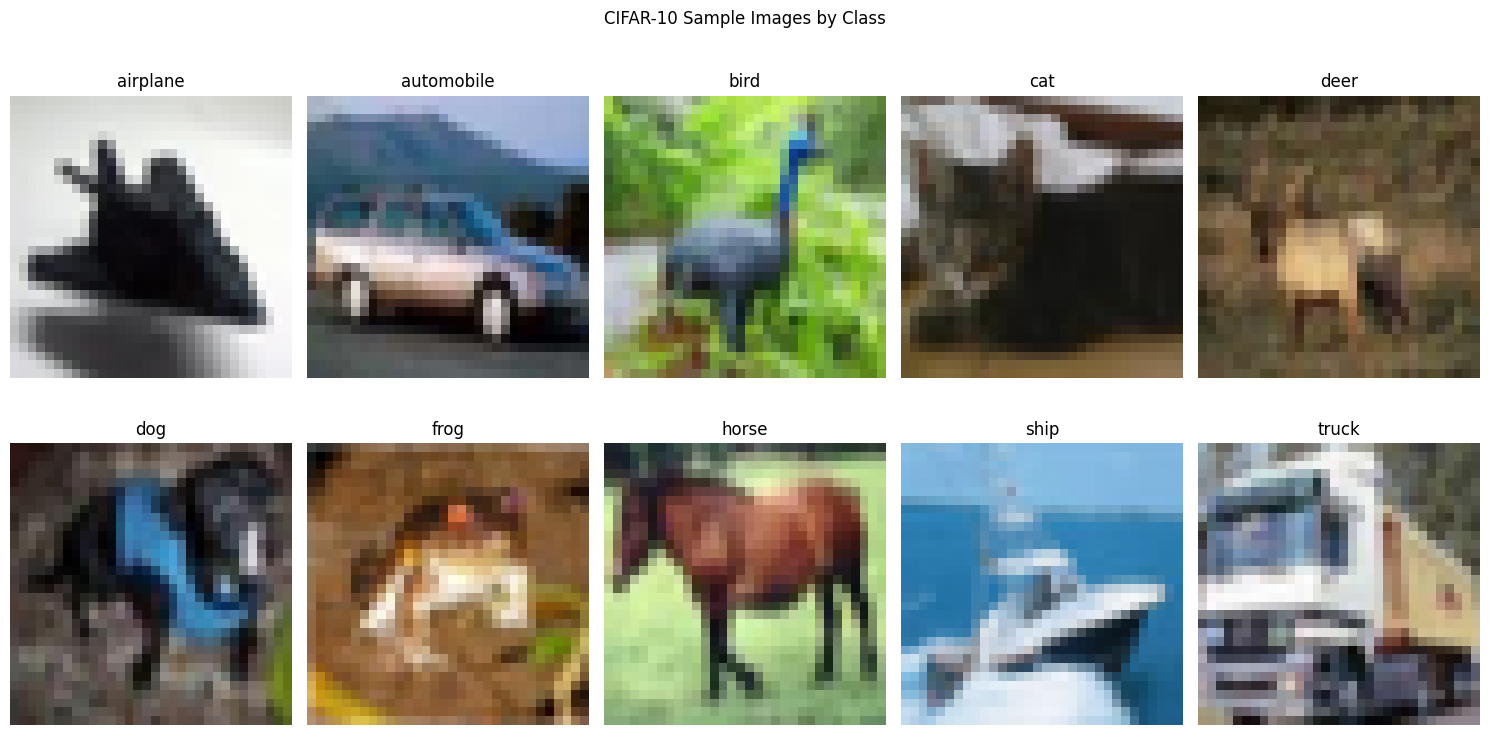

CIFAR-10 Dataset:
Training images: 50000
Image shape: (32, 32, 3)
Data type: uint8
Min pixel value: 0, Max pixel value: 255
=== GAN Improvement Comparison Study ===
FID Evaluator initialized
Computing real data statistics using 1000 samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Real data statistics calculated from 1000 images


=== Training Configuration: baseline ===
Settings:
  use_feature_matching: False
  use_minibatch_disc

  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/3 completed in 16.95s
Generator Loss: 4.0990
Discriminator Loss: 0.9505
D(x): 0.7329, D(G(z)): 0.0880
Real Acc: 0.7797, Fake Acc: 0.9644
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/3 completed in 9.41s
Generator Loss: 1.5691
Discriminator Loss: 1.0489
D(x): 0.6587, D(G(z)): 0.1755
Real Acc: 0.7197, Fake Acc: 0.9352
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3/3 completed in 9.41s
Generator Loss: 1.5053
Discriminator Loss: 1.0838
D(x): 0.6506, D(G(z)): 0.1904
Real Acc: 0.7153, Fake Acc: 0.9279
--------------------------------------------------------------------------------
Training completed in 0.60 minutes


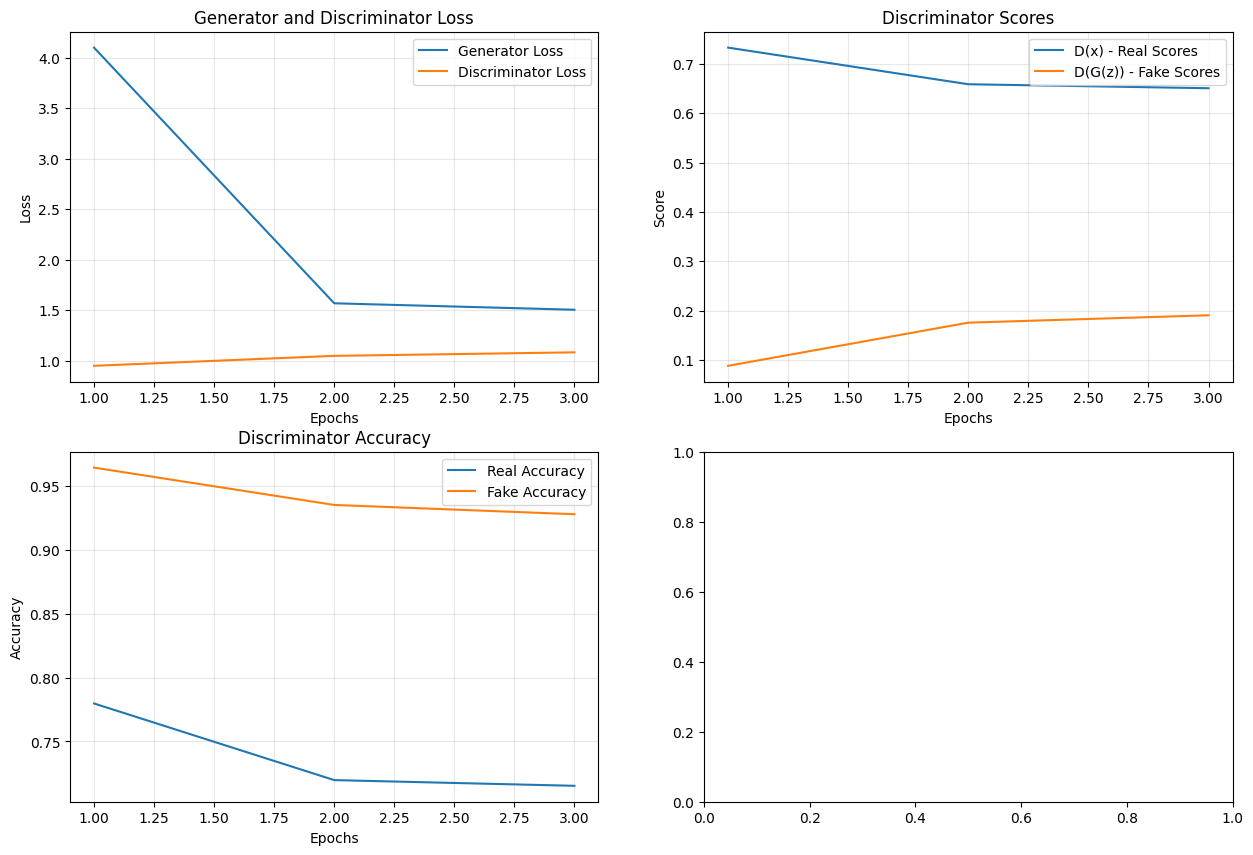

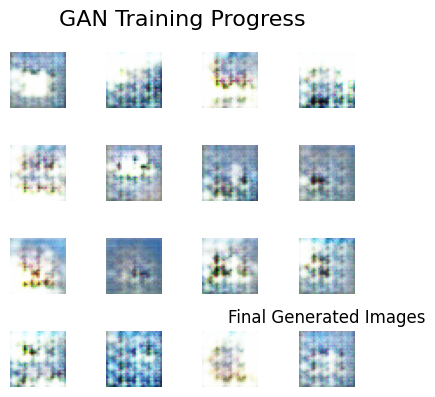

Calculating FID score using 1000 generated samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
FID Score: 327.7942 (lower is better)


=== Training Configuration: feature_matching ===
Settings:
  use_feature_matching: True
  use_minibatch_discrimination: False
  use_historical_averaging: False
  label_smoothing: 0.0


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/3 completed in 16.41s
Generator Loss: 4.1195
Discriminator Loss: 0.9387
D(x): 0.7380, D(G(z)): 0.0694
Real Acc: 0.7837, Fake Acc: 0.9783
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/3 completed in 10.22s
Generator Loss: 1.7907
Discriminator Loss: 0.9912
D(x): 0.6861, D(G(z)): 0.1463
Real Acc: 0.7427, Fake Acc: 0.9477
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3/3 completed in 9.56s
Generator Loss: 1.5441
Discriminator Loss: 1.0278
D(x): 0.6687, D(G(z)): 0.1820
Real Acc: 0.7351, Fake Acc: 0.9307
--------------------------------------------------------------------------------
Training completed in 0.60 minutes


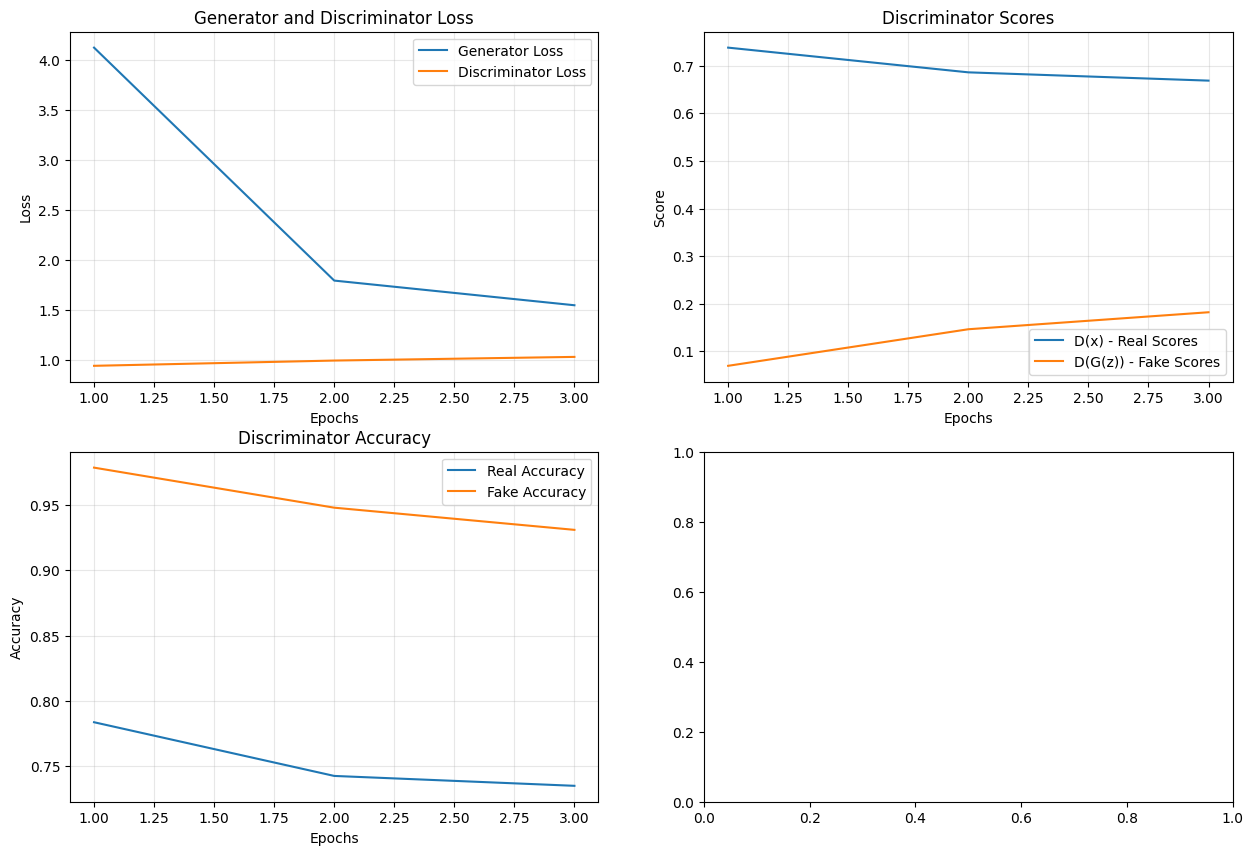

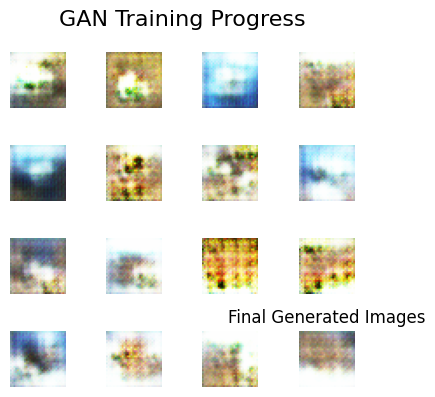

Calculating FID score using 1000 generated samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
FID Score: 259.2309 (lower is better)


=== Training Configuration: minibatch_disc ===
Settings:
  use_feature_matching: False
  use_minibatch_discrimination: True
  use_historical_averaging: False
  label_smoothing: 0.0


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/3 completed in 17.58s
Generator Loss: 4.2836
Discriminator Loss: 0.8765
D(x): 0.7979, D(G(z)): 0.0702
Real Acc: 0.8282, Fake Acc: 0.9571
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/3 completed in 10.20s
Generator Loss: 2.0259
Discriminator Loss: 0.9538
D(x): 0.7147, D(G(z)): 0.1418
Real Acc: 0.7709, Fake Acc: 0.9233
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3/3 completed in 10.16s
Generator Loss: 1.8739
Discriminator Loss: 0.9084
D(x): 0.7195, D(G(z)): 0.1593
Real Acc: 0.7831, Fake Acc: 0.9140
--------------------------------------------------------------------------------
Training completed in 0.63 minutes


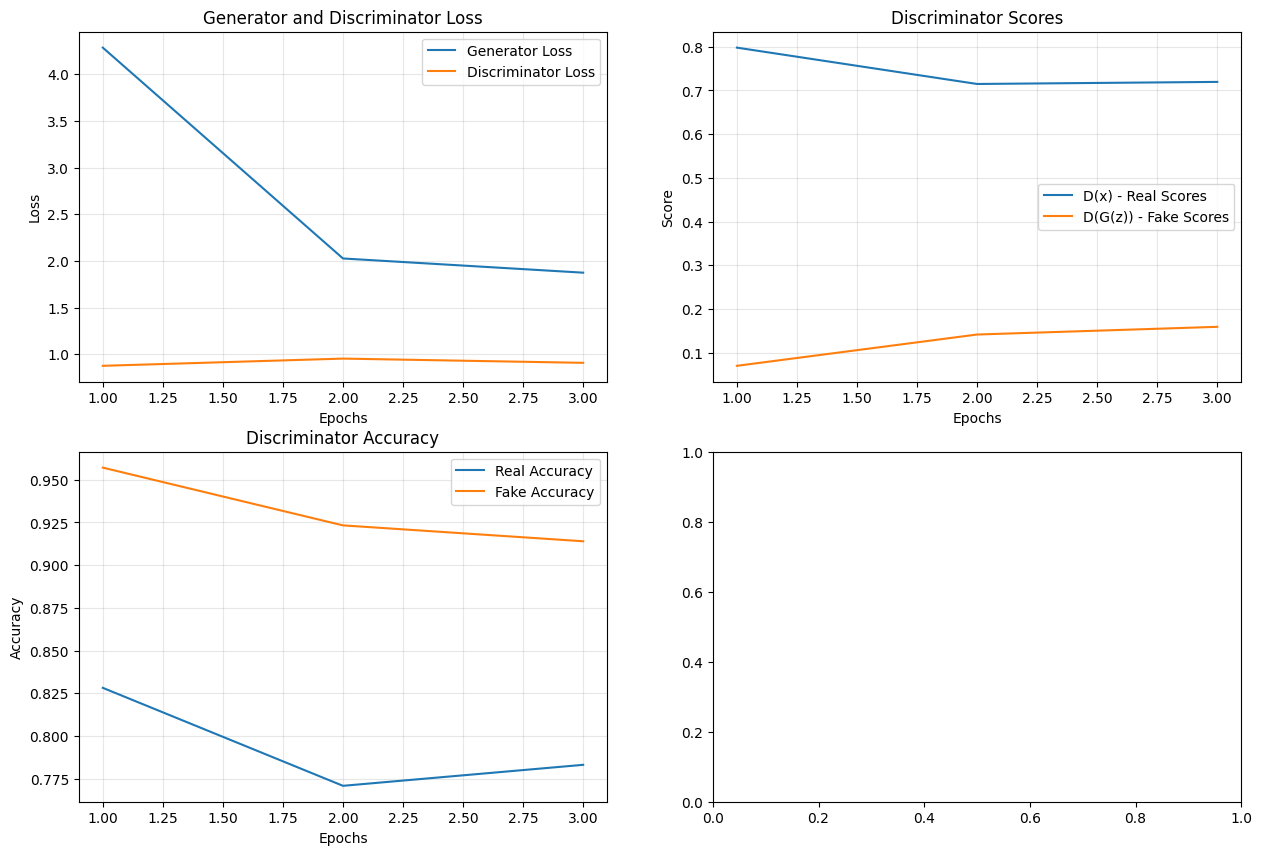

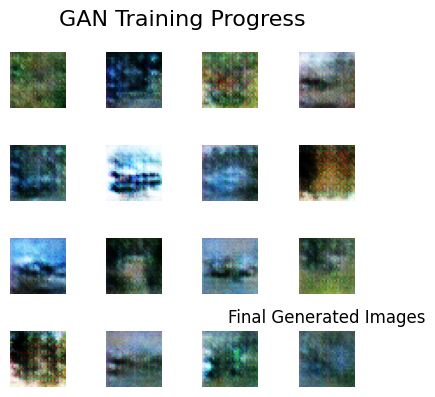

Calculating FID score using 1000 generated samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
FID Score: 273.9674 (lower is better)


=== Training Configuration: historical_avg ===
Settings:
  use_feature_matching: False
  use_minibatch_discrimination: False
  use_historical_averaging: True
  label_smoothing: 0.0


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/3 completed in 17.40s
Generator Loss: 3.8299
Discriminator Loss: 0.9196
D(x): 0.7484, D(G(z)): 0.0651
Real Acc: 0.7949, Fake Acc: 0.9795
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/3 completed in 9.53s
Generator Loss: 1.5736
Discriminator Loss: 1.0455
D(x): 0.6625, D(G(z)): 0.1717
Real Acc: 0.7229, Fake Acc: 0.9390
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3/3 completed in 9.55s
Generator Loss: 1.3880
Discriminator Loss: 1.1507
D(x): 0.6276, D(G(z)): 0.2021
Real Acc: 0.6880, Fake Acc: 0.9298
--------------------------------------------------------------------------------
Training completed in 0.61 minutes


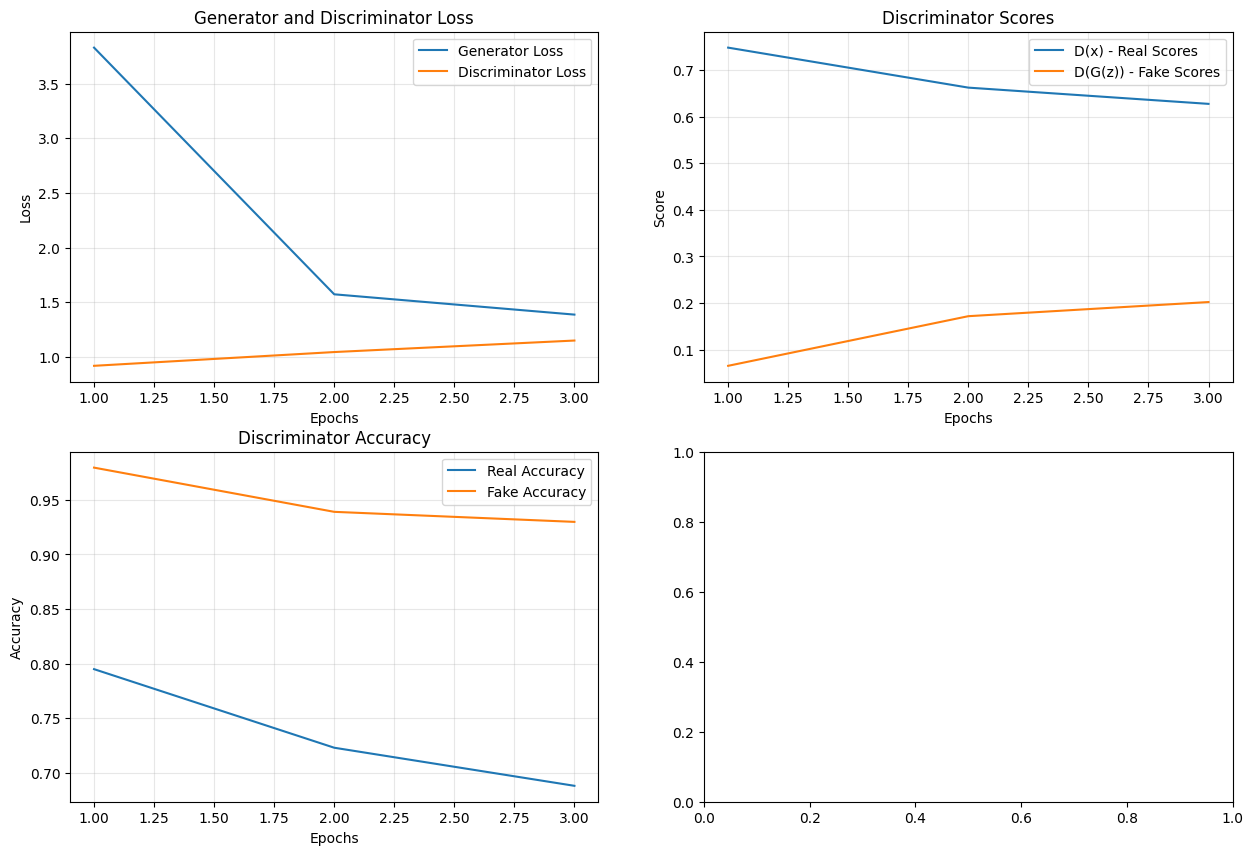

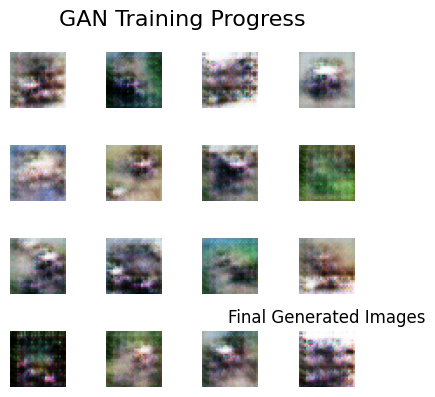

Calculating FID score using 1000 generated samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
FID Score: 282.0658 (lower is better)


=== Training Configuration: label_smoothing ===
Settings:
  use_feature_matching: False
  use_minibatch_discrimination: False
  use_historical_averaging: False
  label_smoothing: 0.25


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/3 completed in 16.26s
Generator Loss: 2.8623
Discriminator Loss: 1.1682
D(x): 0.5405, D(G(z)): 0.0810
Real Acc: 0.5543, Fake Acc: 0.9919
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/3 completed in 9.51s
Generator Loss: 1.3402
Discriminator Loss: 1.2130
D(x): 0.4637, D(G(z)): 0.1818
Real Acc: 0.4164, Fake Acc: 0.9793
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3/3 completed in 9.49s
Generator Loss: 1.3177
Discriminator Loss: 1.2141
D(x): 0.4565, D(G(z)): 0.1826
Real Acc: 0.3995, Fake Acc: 0.9813
--------------------------------------------------------------------------------
Training completed in 0.59 minutes


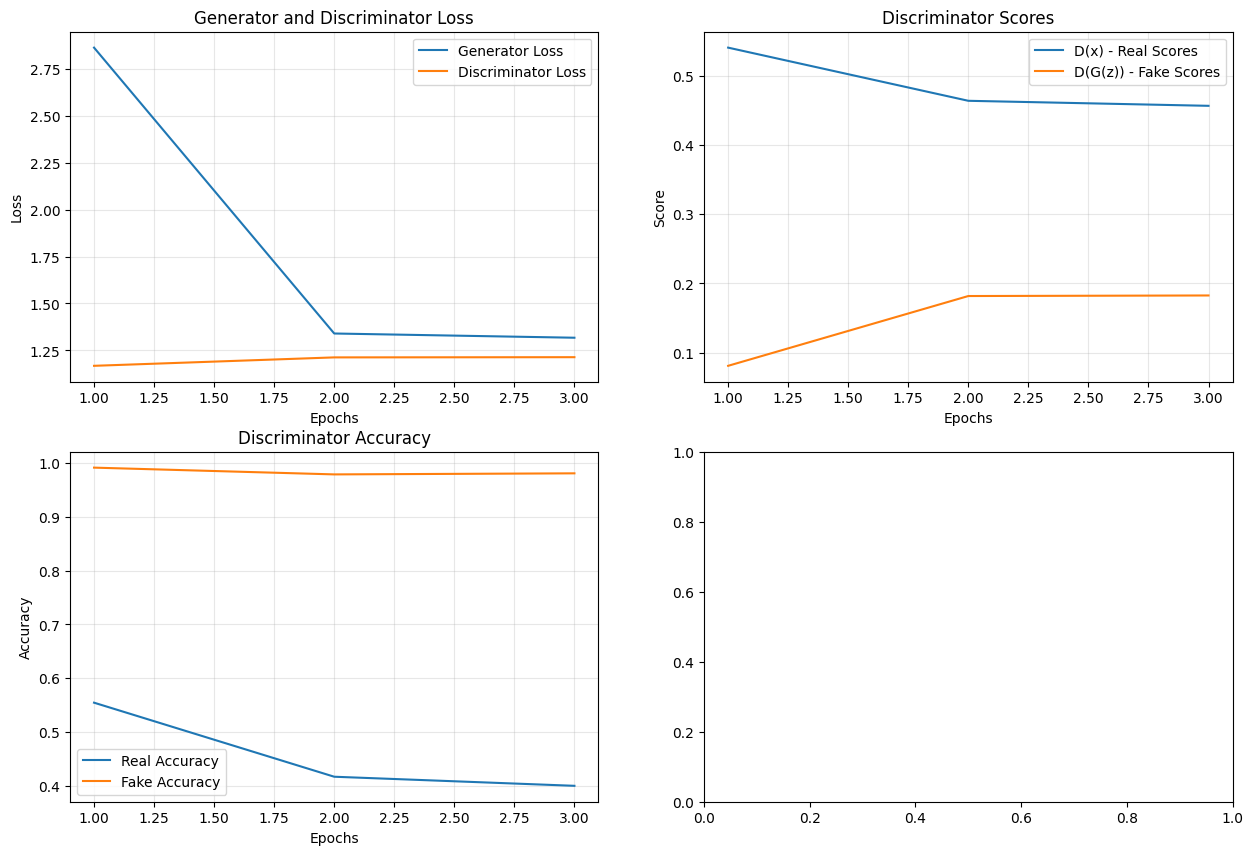

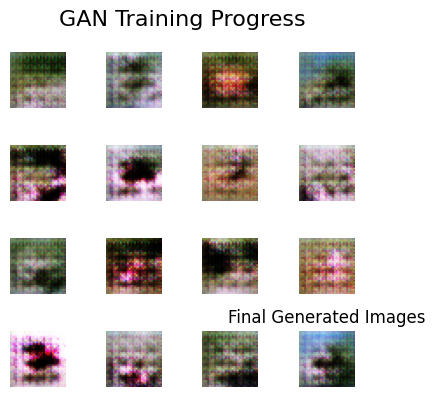

Calculating FID score using 1000 generated samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
FID Score: 257.4427 (lower is better)


=== Training Configuration: all_improvements ===
Settings:
  use_feature_matching: True
  use_minibatch_discrimination: True
  use_historical_averaging: True
  label_smoothing: 0.25


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/3 completed in 18.56s
Generator Loss: 3.1928
Discriminator Loss: 1.2259
D(x): 0.5920, D(G(z)): 0.0662
Real Acc: 0.6186, Fake Acc: 0.9782
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/3 completed in 10.17s
Generator Loss: 1.6871
Discriminator Loss: 1.1471
D(x): 0.5208, D(G(z)): 0.1419
Real Acc: 0.5275, Fake Acc: 0.9654
--------------------------------------------------------------------------------


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3/3 completed in 10.16s
Generator Loss: 1.5702
Discriminator Loss: 1.1229
D(x): 0.5153, D(G(z)): 0.1547
Real Acc: 0.5250, Fake Acc: 0.9658
--------------------------------------------------------------------------------
Training completed in 0.65 minutes


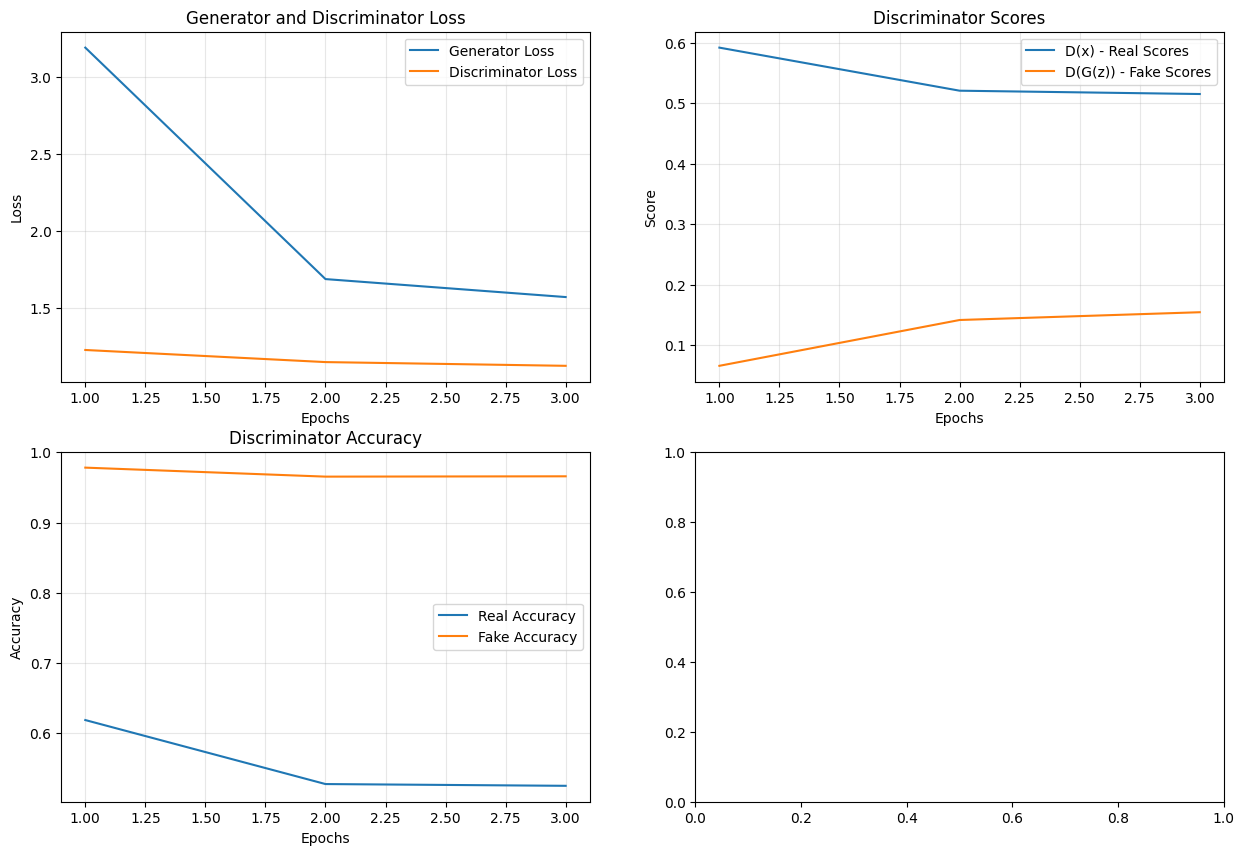

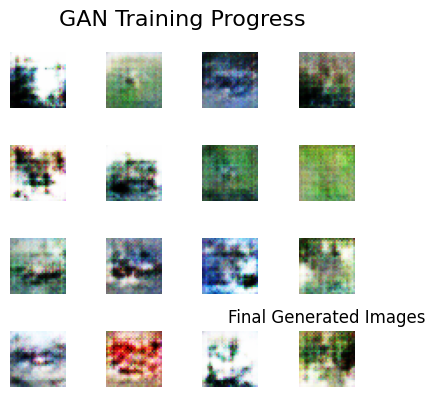

Calculating FID score using 1000 generated samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
FID Score: 279.6780 (lower is better)
Creating comparative visualizations...


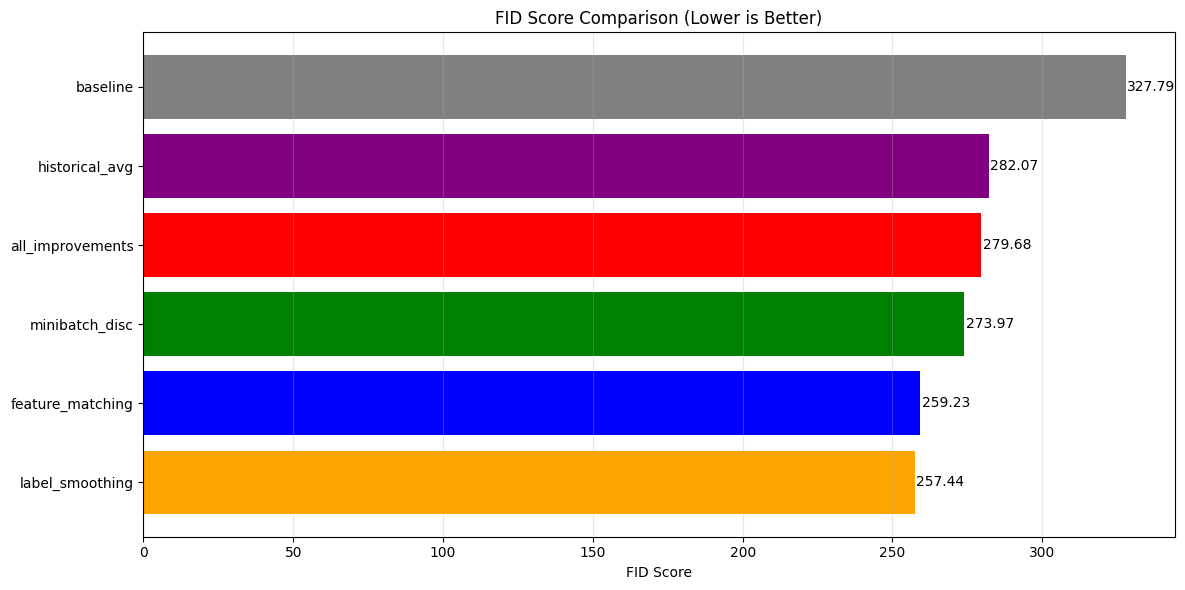

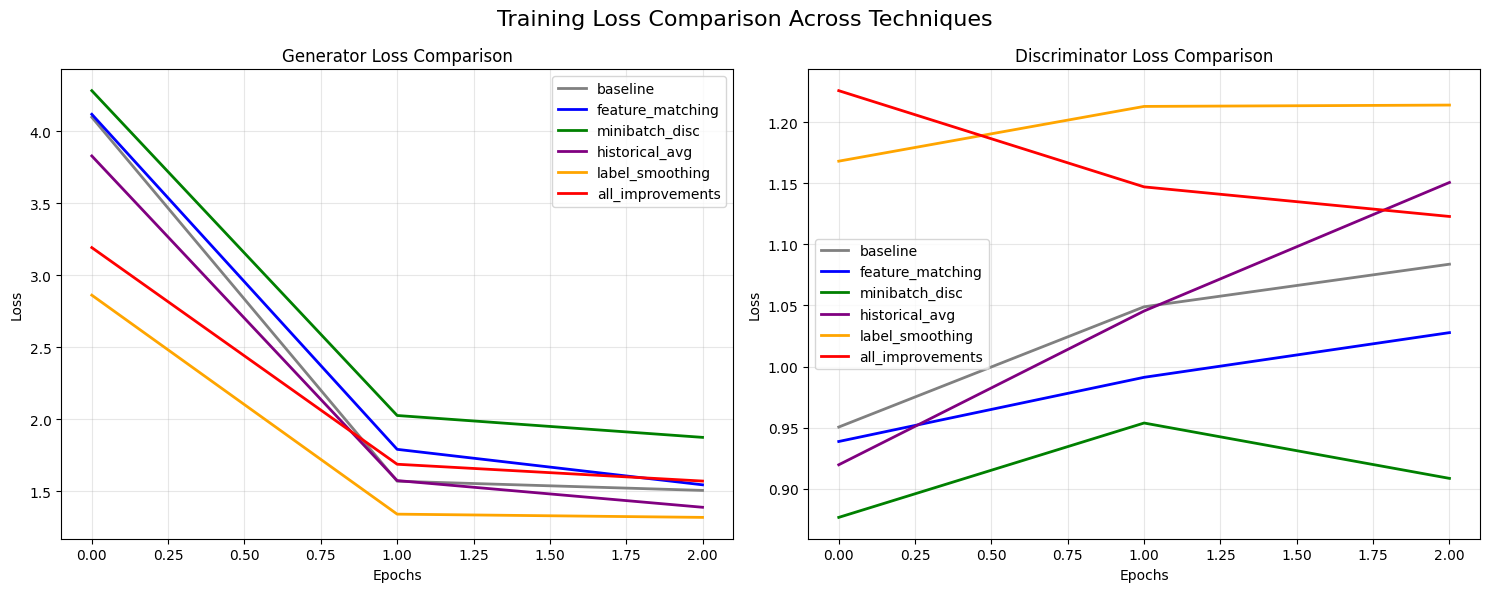

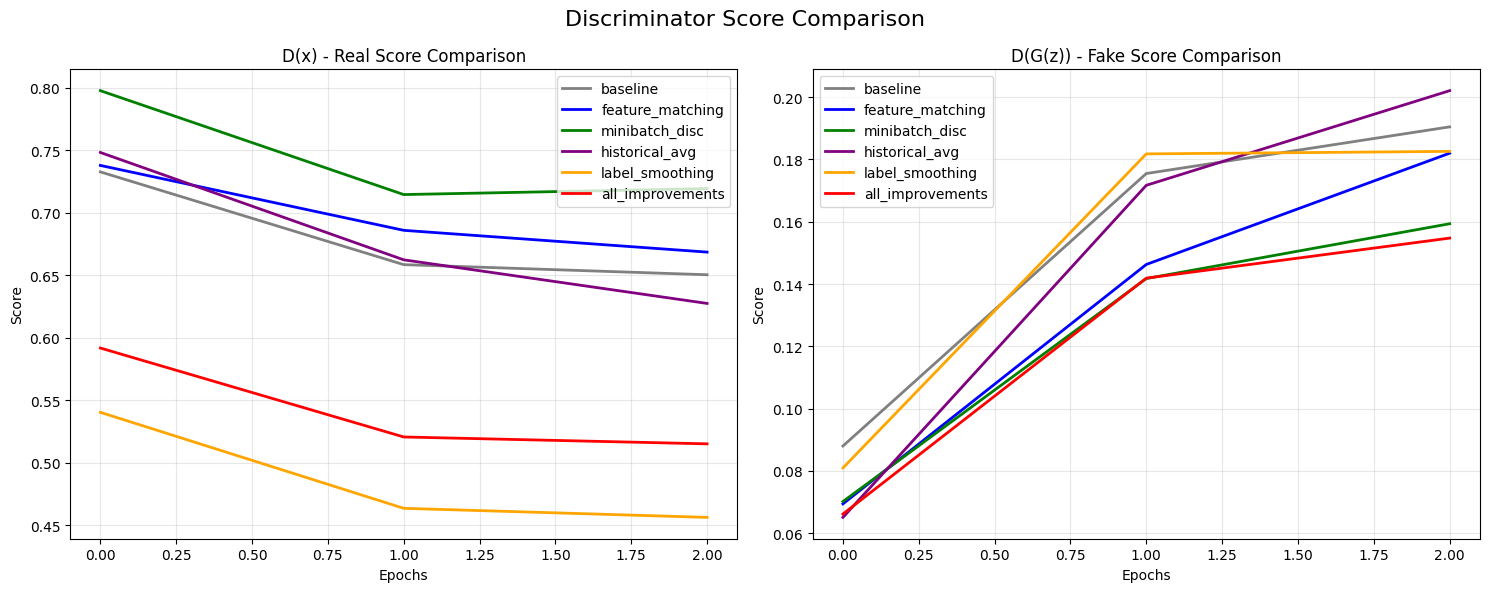

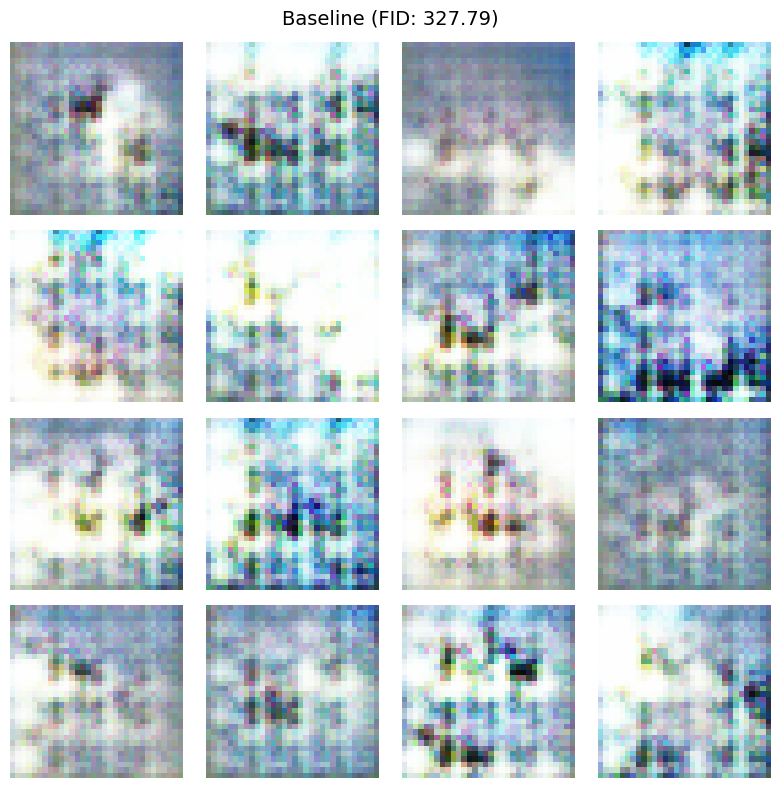

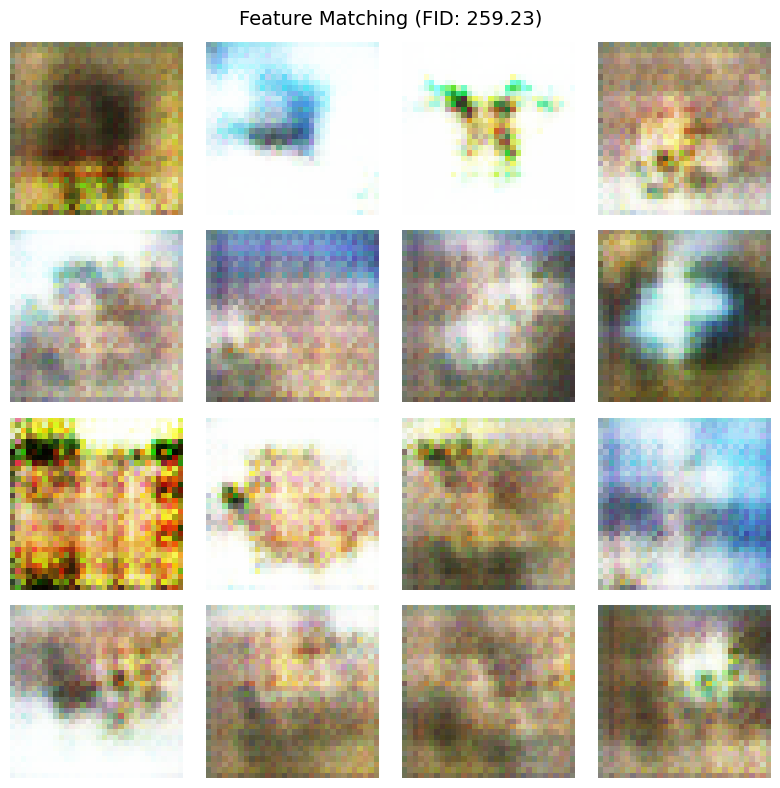

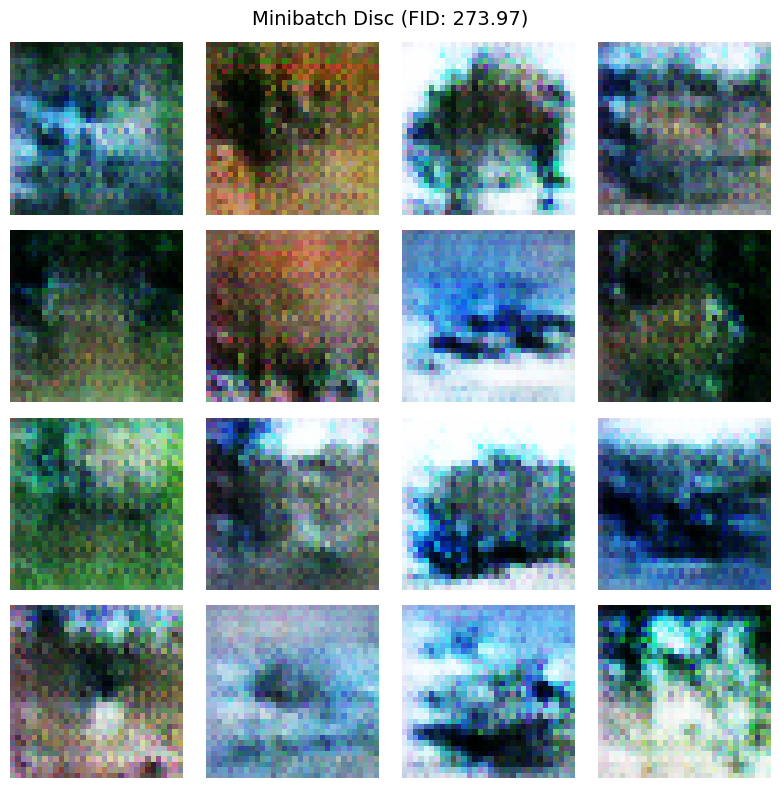

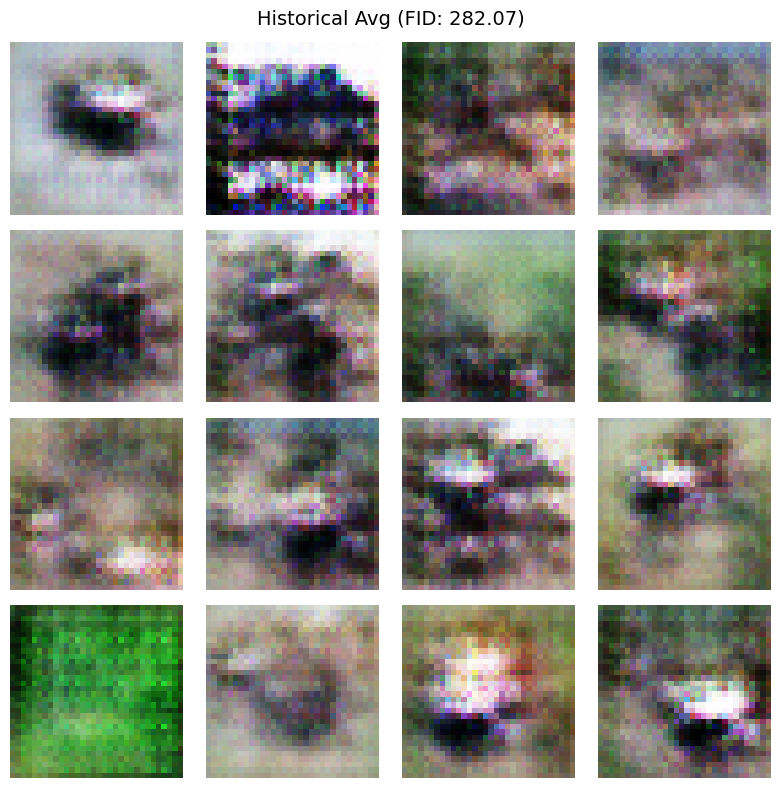

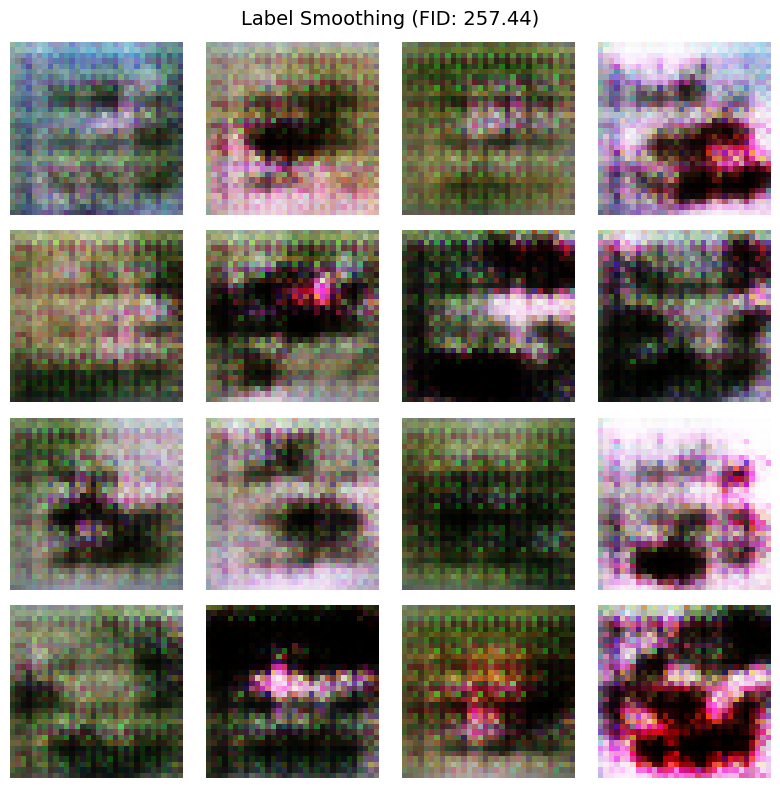

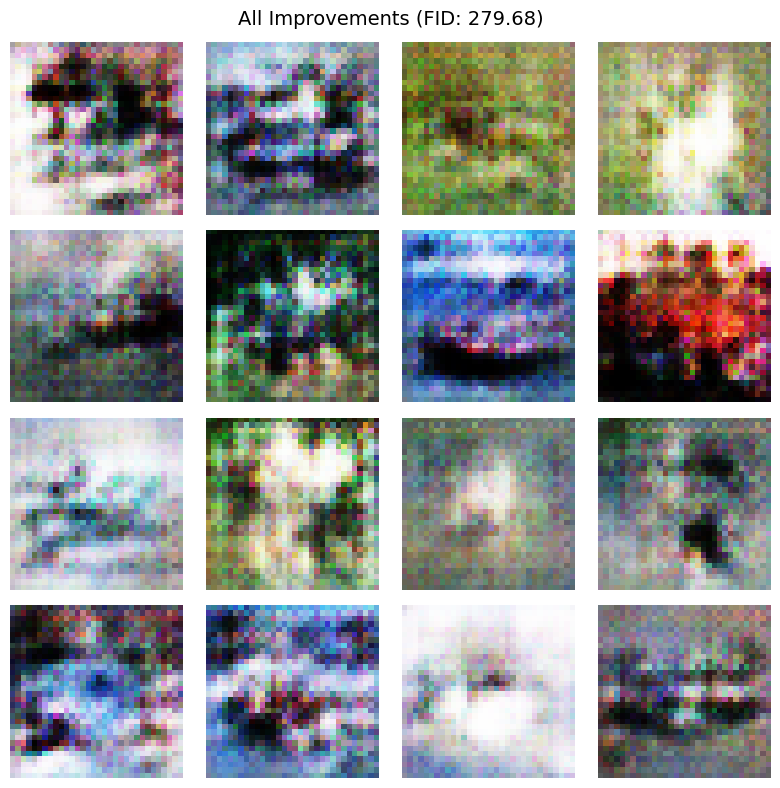


Summary of Results:
----------------------------------------------------------------------------------------------------
Configuration        FID Score    Gen Loss     Disc Loss    D(x)         D(G(z))     
----------------------------------------------------------------------------------------------------
label_smoothing      257.4427     1.3177       1.2141       0.4565       0.1826      
feature_matching     259.2309     1.5441       1.0278       0.6687       0.1820      
minibatch_disc       273.9674     1.8739       0.9084       0.7195       0.1593      
all_improvements     279.6780     1.5702       1.1229       0.5153       0.1547      
historical_avg       282.0658     1.3880       1.1507       0.6276       0.2021      
baseline             327.7942     1.5053       1.0838       0.6506       0.1904      
----------------------------------------------------------------------------------------------------
Analyzing mode collapse across configurations...
32/32 ━━━━━━━━━━━━━━━━━━━

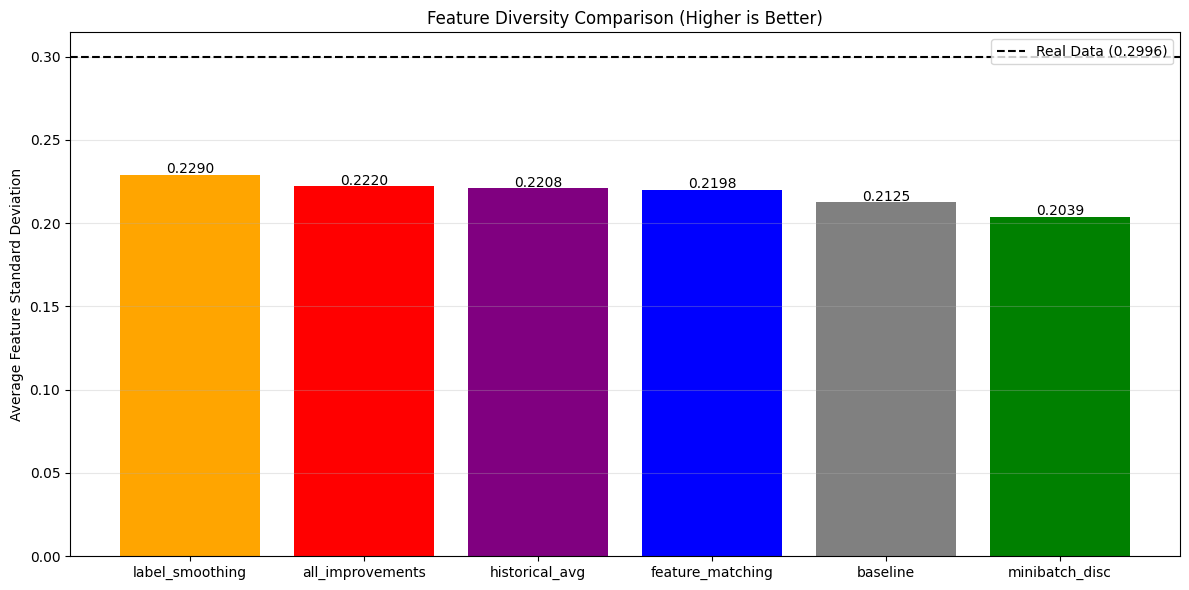


Mode Collapse Analysis:
--------------------------------------------------------------------------------
Configuration        Feature Std     % of Real       Mode Collapse  
--------------------------------------------------------------------------------
label_smoothing      0.2290          76.45          % Minor          
all_improvements     0.2220          74.10          % Minor          
historical_avg       0.2208          73.71          % Minor          
feature_matching     0.2198          73.37          % Minor          
baseline             0.2125          70.92          % Minor          
minibatch_disc       0.2039          68.05          % Moderate       
--------------------------------------------------------------------------------
Real Data Reference: 0.2996
--------------------------------------------------------------------------------

Total experiment time: 5.99 minutes

=== Comprehensive Experiment Summary ===
Dataset: cifar10
Training epochs per configuration: 3
-

In [36]:
# Run a shortened experiment for demonstration
results = run_complete_experiment(epochs=3, dataset_name='cifar10')